# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import dill
import pickle
from wakepy import keep
import time
from usefull import notify
from concurrent.futures import ProcessPoolExecutor,ThreadPoolExecutor,as_completed
import os

from sklearn.linear_model import LinearRegression, Ridge
import statsmodels as sm
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.seasonal import STL,MSTL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

import tensorflow as tf
import xgboost as xgb
import prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta, datetime
from pathlib import Path
from itertools import cycle

2025-06-15 20:10:38.304037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750014638.395218    4204 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750014638.421237    4204 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 20:10:38.666752: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Useful functions

In [2]:
def test_model(model,x):
    forecast=model.forecast(x)
    ax=pd.DataFrame(forecast).plot()
    val.iloc[:x].plot(ax=ax)
    plt.legend(['prediction','y'])

def show_predictions(pred):
    plt.plot(pred)
    plt.plot(val.iloc[:len(pred)].values)
    plt.legend(['prediction','y'])
# def check_freq(x,fr,power):
#     freq=1/x
#     closest=np.argmin(fr-)

# Loading and dividing

In [2]:
data_files=[str(x) for x in  Path().glob('*.xlsx')]
print(data_files)
df=pd.DataFrame()
for month,file in zip(cycle(range(12)),sorted(data_files*12)):
    df=pd.concat([df,pd.read_excel(file,sheet_name=month,skiprows=11)],axis=1)


['Потребление_2024.xlsx', '2022.xlsx', '2023.xlsx']


In [3]:
df=df.iloc[:-3]
df=df.dropna(axis=1)
df=df.loc[:,~df.columns.duplicated()]
df=df.set_index('Время (московское)')

df=df.unstack()
df=df.reset_index()

df.index=pd.date_range(df['level_0'][0],df['level_0'].iloc[-1]+timedelta(hours=23),freq='h')
df=df.drop(['level_0','Время (московское)'],axis=1)
df=df/1e6
df[0]=df[0].astype('float')
df.columns=['y']

In [4]:
val=df['2024-01-01 01':'2024-06-01']
test=df['2024-06-01':]
tr=df[:'2024-01-01 00']

## Допилить

In [6]:
# df['hours']=df['Время (московское)'].str[:2].astype(int)
# df['hours']=pd.to_timedelta(df['hours'],unit='h')
# df['time']=pd.to_datetime(df['level_0'])+df['hours']
# df=df.set_index('time').to_period('h')
# df=df.drop(['level_0','Время (московское)','hours'],axis=1)

#  COPIED FOR FUTURE
# import pandas as pd
# days_to_shift = pd.TimedeltaIndex(6 - launch_df['launch_dt'].dt.dayofweek)
# launch_df['launch_dt'] = launch_df['launch_dt'] + days_to_shift


In [7]:
# проработать случай если не все 11 месяцев
#  Old code

# for x in range(12):
#     df=pd.concat([df,pd.read_excel('Потребление_2024.xlsx',sheet_name=x,index_col=0)],axis=1)
# df=df.iloc[:-3]
# df=df.dropna(axis=1)
# df=df.loc[:,~df.columns.duplicated()]   # убираем повторяющееся московское время
# df=df.set_index('Время (московское)')
# df=df.unstack()
# df=df.reset_index()
# df.level_0=pd.to_datetime(df.level_0)
# df['hour']=df['Время (московское)'].str.extract(r'(\d{2}:\d{2})')[0]
# df['datetime']=pd.to_datetime(df['level_0'].dt.strftime('%Y-%m-%d')+' '+df['hour'])
# df=df.drop(['level_0','Время (московское)','hour'],axis=1)
# df=df.set_index('datetime')
# # df=df.asfreq('h')
# df.columns=['y']

# df

# Describing data

## Графики данных

Text(0, 0.5, 'Электропотребление кВт*ч')

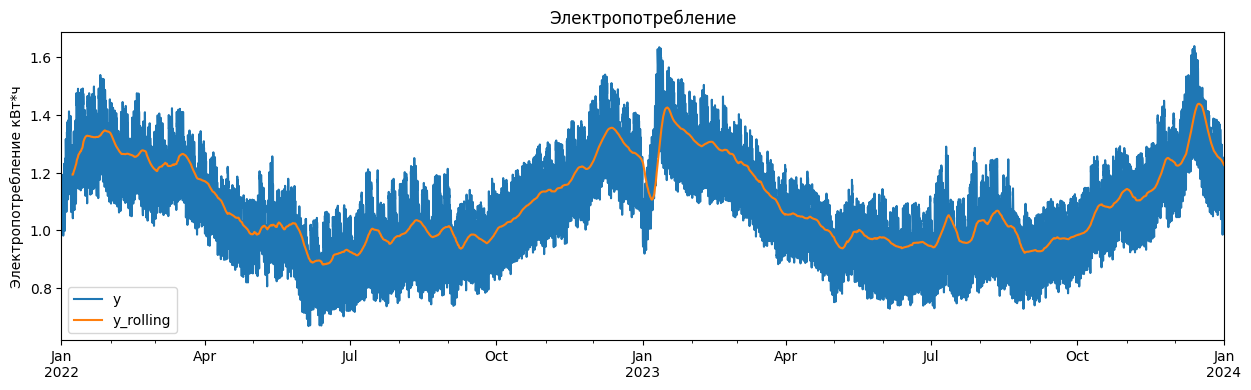

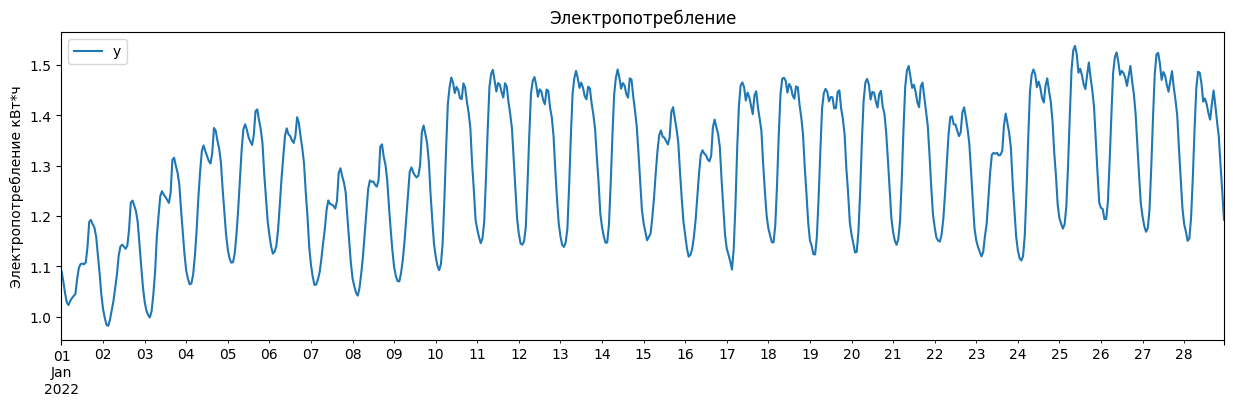

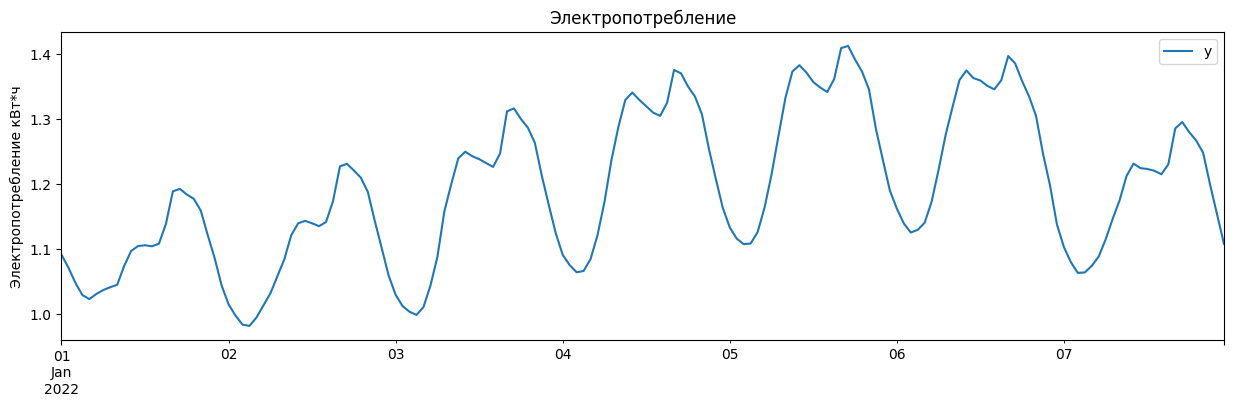

In [21]:
fig,ax=plt.subplots(1, 1, figsize=(15, 4))
ax=tr.plot(ax=ax)
tr.rolling(7*24).mean().plot(ax=ax,title='Электропотребление')
ax.set_ylabel('Электропотребление кВт*ч')
ax.legend(['y','y_rolling'])
ax=tr.iloc[:24*7*4].plot(figsize=(15,4),title='Электропотребление')
ax.set_ylabel('Электропотребление кВт*ч')
ax=tr.iloc[:24*7].plot(figsize=(15,4),title='Электропотребление')
ax.set_ylabel('Электропотребление кВт*ч')


## Исследование

In [79]:
display(tr.describe().T)
tr

count      mean      std       min       25%       50%       75%  \
y  17521.0  1.100724  0.18069  0.668062  0.981664  1.087883  1.222567   

        max  
y  1.638573

y
2022-01-01 00:00:00  1.091008
2022-01-01 01:00:00  1.071098
2022-01-01 02:00:00  1.047833
2022-01-01 03:00:00  1.029009
2022-01-01 04:00:00  1.022884
...                       ...
2023-12-31 20:00:00  1.159665
2023-12-31 21:00:00  1.118060
2023-12-31 22:00:00  1.076599
2023-12-31 23:00:00  1.042254
2024-01-01 00:00:00  1.021325

[17521 rows x 1 columns]

<Axes: >

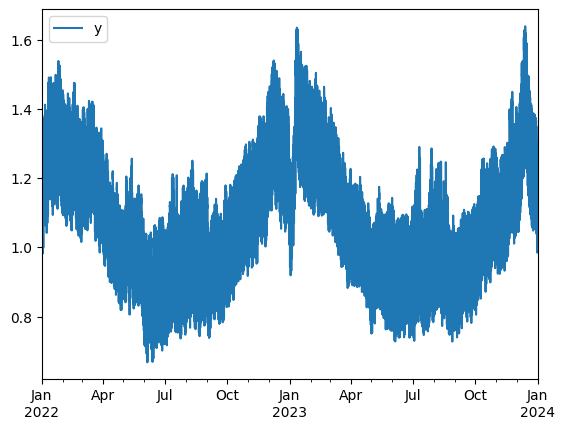

In [9]:
tr.plot()

count      mean      std       min       25%       50%       75%  \
y  17521.0  1.100724  0.18069  0.668062  0.981664  1.087883  1.222567   

        max  
y  1.638573

Text(0.5, 1.0, 'Гистограмма электропотребления')

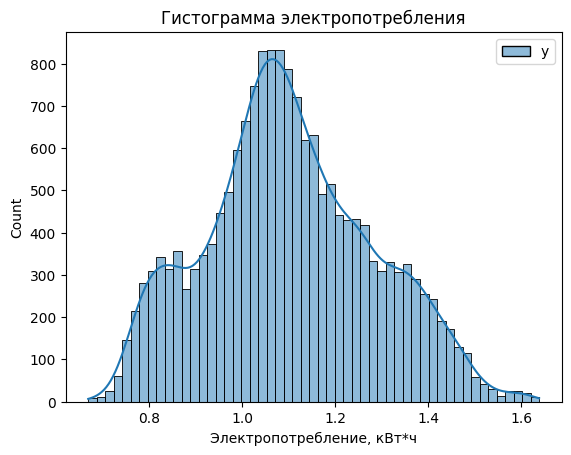

In [14]:
display(tr.describe().T)
ax=sns.histplot(tr,kde=True)
ax.set_xlabel('Электропотребление, кВт*ч')
ax.set_title('Гистограмма электропотребления')

Text(0, 0.5, 'Стандартное отклонение')

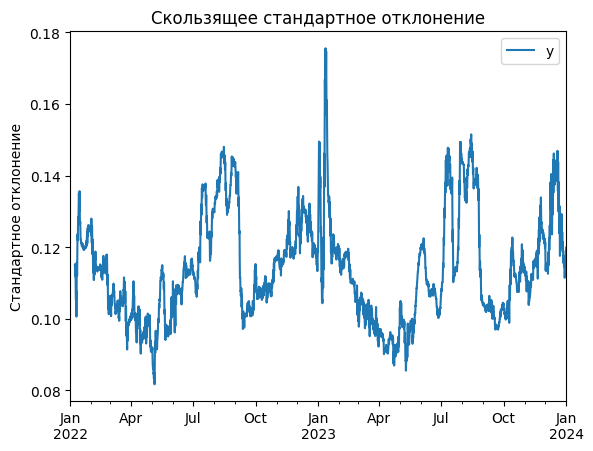

In [23]:
ax=tr.rolling(168).std().plot(label='7-day STD',title='Скользящее стандартное отклонение')
ax.set_ylabel('Стандартное отклонение')


AttributeError: 'list' object has no attribute 'set_title'

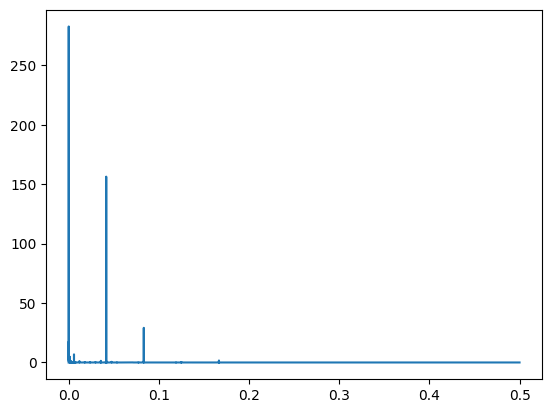

In [36]:
from scipy.signal import periodogram
from scipy.signal import detrend

signal_detrended = detrend(tr.values.flatten())
f, Pxx_den=periodogram(signal_detrended)
ax=plt.plot(f, Pxx_den)
ax.set_title('Периодограмма')
ax.set_ylabel('Сила сезона')
ax.set_ylabel('Сезон, час')

In [35]:
type(ax[0])

matplotlib.lines.Line2D

In [13]:
from scipy.signal import find_peaks
power=Pxx_den
# Assuming you already have frequencies and power from periodogram()
peaks, _ = find_peaks(power)  # height can be adjusted for sensitivity

# Get top N peaks
top_n = 10
sorted_indices = np.argsort(power[peaks])[-top_n:][::-1]
significant_peaks = peaks[sorted_indices]

for peak in significant_peaks:
    freq = f[peak]
    print(f"Frequency: {freq:.6f} cycles/hour → Period: {1/freq:.1f} hours → Power: {power[peak]:.2f}")

Frequency: 0.000114 cycles/hour → Period: 8760.0 hours → Power: 282.75
Frequency: 0.041667 cycles/hour → Period: 24.0 hours → Power: 157.18
Frequency: 0.083333 cycles/hour → Period: 12.0 hours → Power: 30.07
Frequency: 0.000228 cycles/hour → Period: 4380.0 hours → Power: 17.87
Frequency: 0.005936 cycles/hour → Period: 168.5 hours → Power: 6.91
Frequency: 0.001027 cycles/hour → Period: 973.3 hours → Power: 4.95
Frequency: 0.000799 cycles/hour → Period: 1251.4 hours → Power: 4.82
Frequency: 0.000342 cycles/hour → Period: 2920.0 hours → Power: 4.80
Frequency: 0.000685 cycles/hour → Period: 1460.0 hours → Power: 2.65
Frequency: 0.001370 cycles/hour → Period: 730.0 hours → Power: 2.43


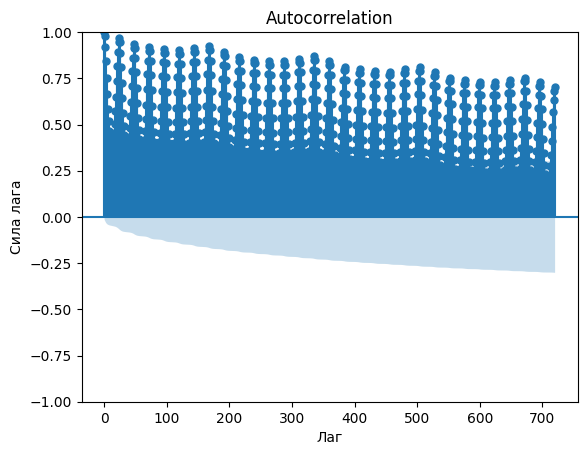

In [49]:
ax.axes[0].set_xlabel('Лаг')
ax.axes[0].set_ylabel('Сила лага')

ax

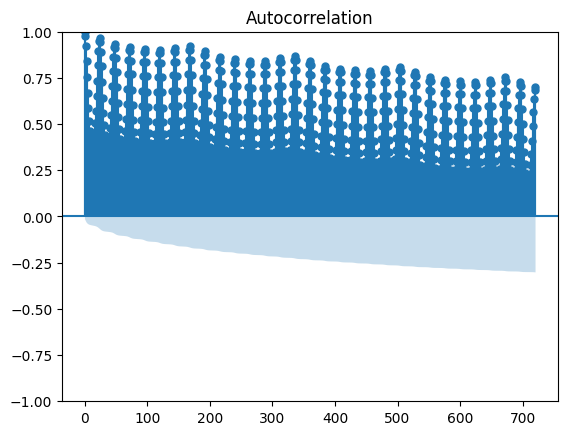

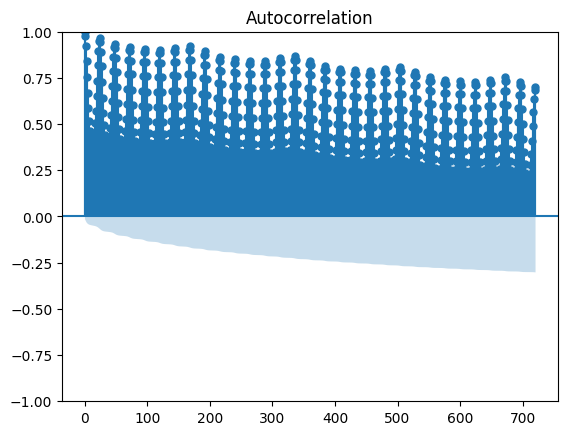

In [48]:
from statsmodels.graphics.tsaplots import plot_acf

ax=plot_acf(tr,lags=720)

plot_acf(tr,lags=720)


plt.show()

In [15]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.datasets import co2
# from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL,MSTL

# result = STL(tr.resample('ME').mean()).fit()
# result.plot()
# plt.show()
# result = seasonal_decompose(
#     tr['y'], model='additive', extrapolate_trend='freq')
# result.plot()
# plt.tight_layout()
# plt.show()


# result = MSTL(tr,periods=[24,24*7,24*365]).fit()
# result.plot()
# plt.show()

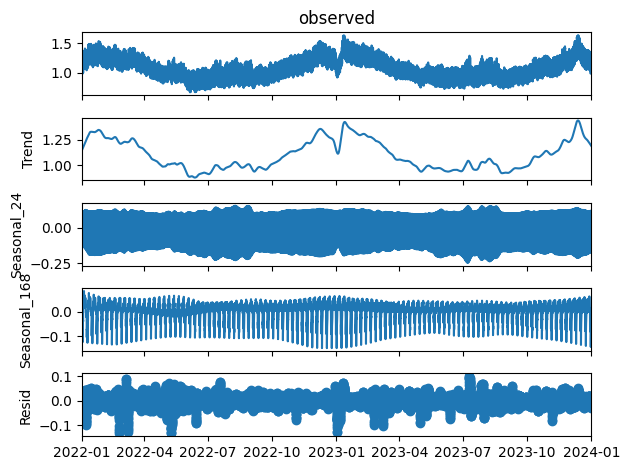

In [55]:
result = MSTL(tr,periods=[24,168]).fit()
result.plot()
plt.show()

In [ ]:
result = MSTL(tr,periods=[24,12,4380,168]).fit()
result.plot()
plt.show()

# Построение моделей

## Naive forecasting

### week lag

In [98]:
from numpy.lib.stride_tricks import sliding_window_view

pred=np.array([])
window=np.append(tr.iloc[-168:].values.flatten(),val.iloc[:-168].values.flatten())

pred=sliding_window_view(window,168).flatten()
true=sliding_window_view(val.values.flatten(),168).flatten()

In [76]:
# pd.Series(pred).to_csv('naive_weekly.csv')
# val.to_csv('validation.csv')
# pd.Series(y_true).to_csv('naive_weekly_true.csv')
# tr.to_csv('training.csv')

In [43]:
pred_fixed=np.array([])
for x in range(0,len(pred),168*168):
    pred_fixed=np.append(pred_fixed,pred[x:x+168])

0.05886404080856898


0.07677973741588583

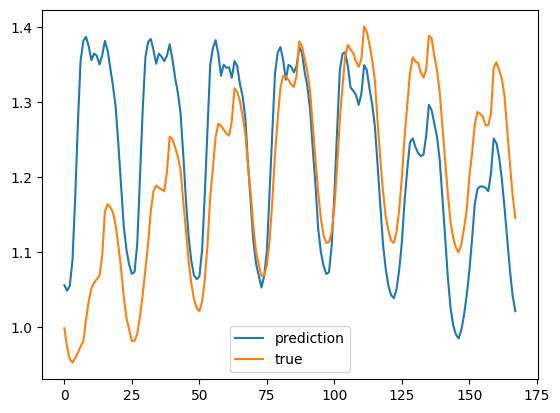

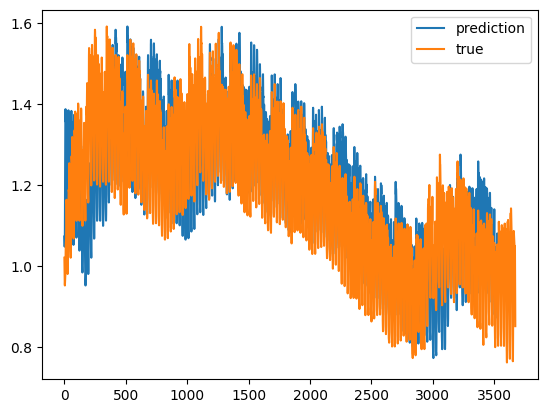

In [100]:
plt.plot(pred[168:168+168])
plt.plot(true[168:168+168])
plt.legend(['prediction','true'])
plt.figure()
plt.plot(pred_fixed)
plt.plot(val.values.flatten())
plt.legend(['prediction','true'])
print(mean_absolute_error(pred,true))
np.sqrt(mean_squared_error(pred,true))

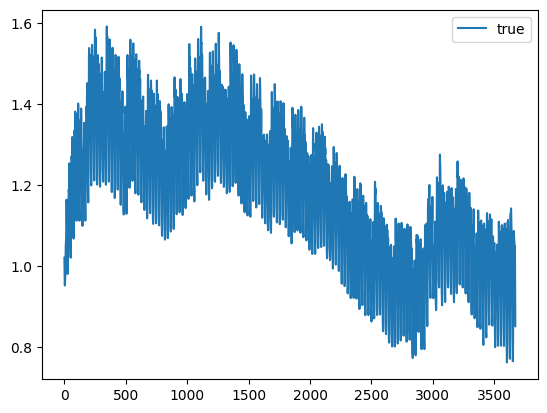

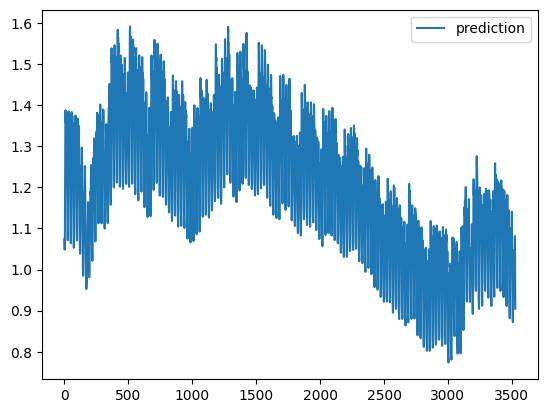

In [26]:
plt.plot(val.values.flatten())
plt.legend(['true'])

plt.figure()

plt.plot(pred_fixed)
plt.legend(['prediction'])


### day lag

In [119]:
day_naive_pred=[]
trc=tr.copy()
valc=val.copy()
for x in range(0,len(val)-168+1):
    last_day = trc[-24:].values.flatten()
    day_naive_pred.append(np.tile(last_day,7))
    trc=pd.concat([trc,valc.iloc[[0]]])
    valc=valc.iloc[1:]

day_naive_pred=np.array(day_naive_pred).flatten()
true_hourly=sliding_window_view(val.values.flatten(),168).flatten()

print('MAE :',mean_absolute_error(true_hourly,day_naive_pred),'\nMRSE :',np.sqrt(mean_squared_error(true_hourly,day_naive_pred)))

MAE : 0.05374592808851177 
MRSE : 0.07208680075139469


In [127]:
len(val)

3672

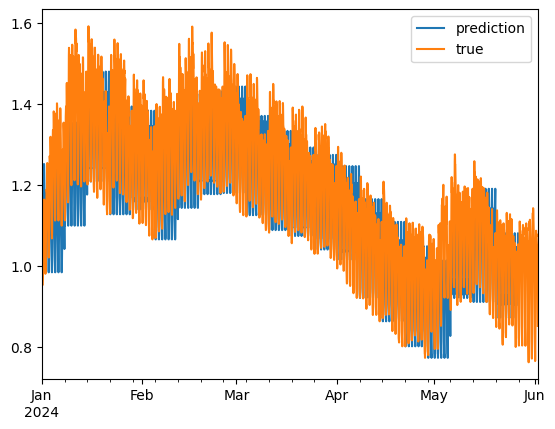

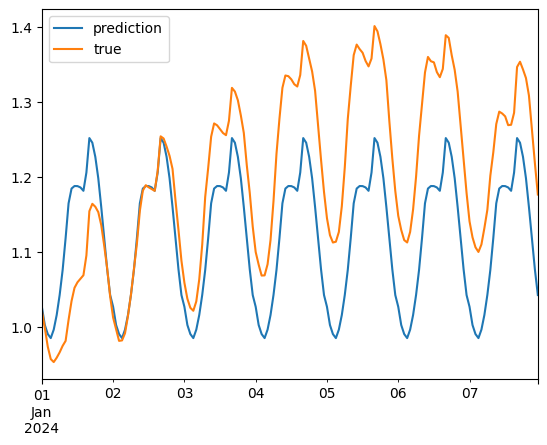

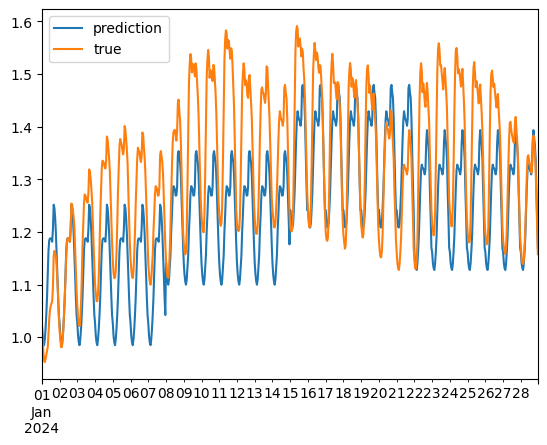

In [129]:
pred_fixed=[]
for x in range(0,len(day_naive_pred),168*168):
    pred_fixed.append(day_naive_pred[x:x+168])
pred_fixed=pd.Series(np.array(pred_fixed).flatten(),index=val.index[:3528])
    
ax=pred_fixed.plot()
val.plot(ax=ax)
plt.legend(['prediction','true'])
plt.figure()
ax=pred_fixed.iloc[:168].plot()
val.iloc[:168].plot(ax=ax)
plt.legend(['prediction','true'])
plt.figure()
ax=pred_fixed.iloc[:168*4].plot()
val.iloc[:168*4].plot(ax=ax)
plt.legend(['prediction','true'])

## TBATS (can't get to work)

In [13]:
from tbats import TBATS
import warnings
import time
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    start = time.time()
    tbats_pre=TBATS(seasonal_periods=[24])
    tbats=tbats_pre.fit(tr.iloc[-24*2:])
    end = time.time()

print('start:',start,' end: ',end)


/home/tip/projects/main/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tip/projects/main/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tip/projects/main/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tip/projects/main/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tip/projects/main/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

KeyboardInterrupt: 

In [ ]:
tbats_pred=tbats.forecast(168)

plt.plot(tbats_pred)
plt.plot(val[:48].values)

## Exponensial smothing

In [22]:
tr

y
2022-01-01 00:00:00  1.091008
2022-01-01 01:00:00  1.071098
2022-01-01 02:00:00  1.047833
2022-01-01 03:00:00  1.029009
2022-01-01 04:00:00  1.022884
...                       ...
2024-03-01 19:00:00  1.380001
2024-03-01 20:00:00  1.346616
2024-03-01 21:00:00  1.289219
2024-03-01 22:00:00  1.238236
2024-03-01 23:00:00  1.190989

[18984 rows x 1 columns]

In [37]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

smoothing_pre = ExponentialSmoothing(tr,trend='add',seasonal='add',seasonal_periods=24)
smoothing=smoothing_pre.fit()
smoothing.forecast()

2024-03-02 00:00:00    1.168805
2024-03-02 01:00:00    1.159784
2024-03-02 02:00:00    1.156969
Freq: h, dtype: float64

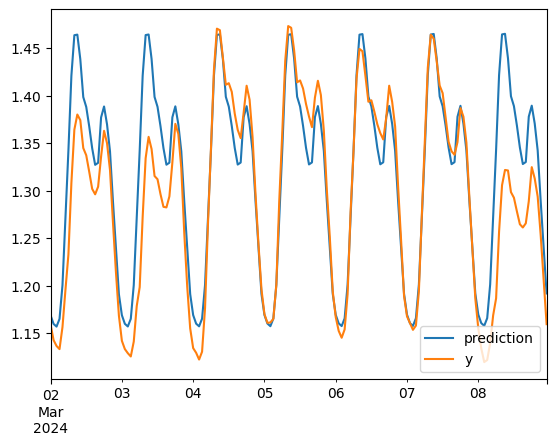

In [45]:
test_model(smoothing,24*7)

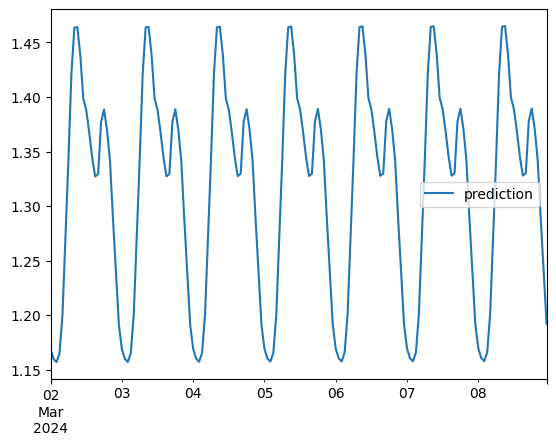

In [62]:
show_predictions(smoothing,24*7)

## Arima

In [37]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
with keep.running():
    model = pm.auto_arima(tr.iloc[-24*60:].values, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=168,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=True,   
                          start_P=0, 
                          D=None, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

# Best model of search on 24: ARIMA(2,0,1)(2,0,2)[24] 

/home/tip/projects/main/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tip/projects/main/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tip/projects/main/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tip/projects/main/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tip/projects/main/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [26]:
# sar_pred.to_pickle("sarima_prediction.pkl")
# sar_pred=pd.read_pickle("sarima_prediction.pkl")


In [19]:
def make_sarima(tr):
    pre_model=SARIMAX(tr, 
            order=(2, 0, 1),
            seasonal_order=(2, 0, 2, 24),
            enforce_stationarity=False, 
            enforce_invertibility=False
            )
    model=pre_model.fit(maxiter=500, disp=False)
    return model

In [23]:
sar_pred=[]
valc=val.copy()
trc=tr.copy()
with keep.running():
    steps=(len(val)-168+1)//24
    with tqdm(total=steps) as pbar:
        for _ in range(0,len(val)-168+1,24):
            pbar.set_postfix(leng=len(sar_pred))
            
            model=make_sarima(trc.iloc[-4380:])
            pred=model.forecast(168)
            
            sar_pred.append(pred)
            
            trc=pd.concat([trc,valc.iloc[:24]])
            valc = valc.iloc[24:]
            
            pbar.update(1)
sar_pred = pd.concat(sar_pred)

/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
147it [1:32:50, 37.90s/it, leng=146]                        

MAE:  0.05217866070189409 
MRSE: 0.06930413860528448


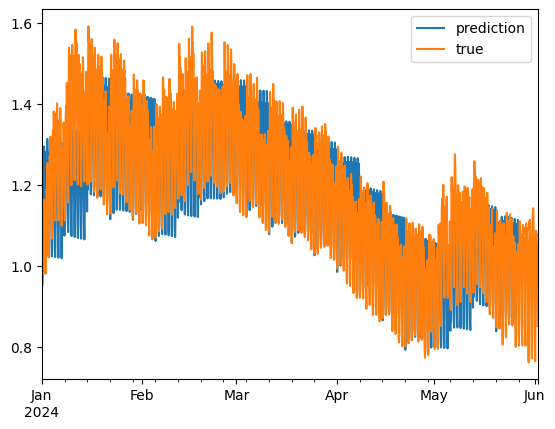

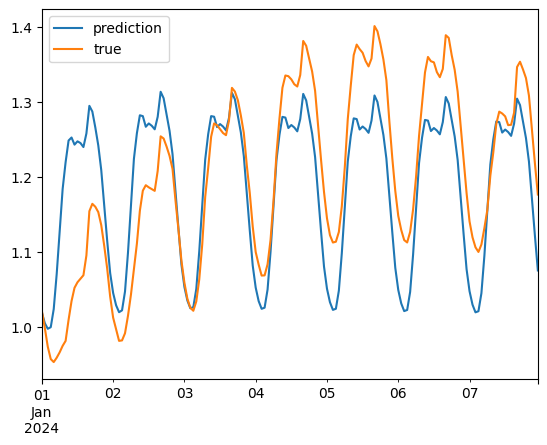

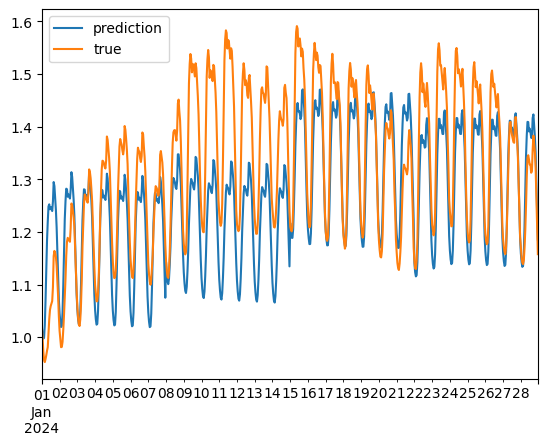

In [31]:
sar_true=val.loc[sar_pred.index]
pred_fixed=[]
for x in range(0,len(sar_pred)- 168 + 1,168*7):
    pred_fixed.append(sar_pred[x:x+168])
pred_fixed=pd.concat(pred_fixed)
    
ax=pred_fixed.plot()
val.plot(ax=ax)
plt.legend(['prediction','true'])
plt.figure()
ax=pred_fixed.iloc[:168].plot()
val.iloc[:168].plot(ax=ax)
plt.legend(['prediction','true'])
plt.figure()
ax=pred_fixed.iloc[:168*4].plot()
val.iloc[:168*4].plot(ax=ax)
plt.legend(['prediction','true'])

print("MAE: ",mean_absolute_error(sar_true,sar_pred), '\nMRSE:', np.sqrt(mean_squared_error(sar_true,sar_pred)))

In [118]:
start = time.time()
pre_model = SARIMAX(tr.iloc[-180*24:], 
                    order=(2, 0, 1),
                    seasonal_order=(2, 0, 2, 24),
                    enforce_stationarity=False, 
                    enforce_invertibility=False
                    )
model=pre_model.fit(maxiter=500, disp=False)
end = time.time()

print(f"SARIMA build time: {end - start:.2f} seconds")

SARIMA build time: 31.61 seconds


## Prophet

In [162]:
# pro_pred.to_pickle("prophet_prediction.pkl")
# pre_pred=pd.read_pickle("prophet_prediction.pkl")

In [151]:
def make_prophe(tr,x=168):
    pro_data=tr.copy()

    pro_data=pro_data.reset_index()
    pro_data=pro_data.rename(columns={'index':'ds'})

    prophet=Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True)
    
    prophet.add_seasonality(name='half_yearly', period=182.5, fourier_order=5)
    
    
    prophet.fit(pro_data)

    future = prophet.make_future_dataframe(periods=x,freq='h')
    pro_forecast=prophet.predict(future)
    future_only = pro_forecast[pro_forecast['ds'] > pro_data['ds'].max()]
    future_only.index=future_only['ds']
    return prophet,future_only['yhat']


In [152]:
import logging

# Suppress cmdstanpy INFO logs

trc=tr.copy()
valc=val.copy()
pro_pred = []

logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
logging.getLogger("prophet").setLevel(logging.WARNING)

with keep.running():
    steps=(len(val)-168+1)//24
    with tqdm(total=steps) as pbar:
        for _ in range(0,len(val)-168+1,24):
            pbar.set_postfix(leng=len(pro_pred))
            
            _,pred=make_prophe(trc)
            
            pro_pred.append(pred)
            
            trc=pd.concat([trc,valc.iloc[:24]])
            valc = valc.iloc[24:]
            
            pbar.update(1)
pro_pred = pd.concat(pro_pred)

147it [56:36, 23.11s/it, leng=146]                                                                                                                                                                                 


In [36]:
pro_true=val.loc[pro_pred.index]
pred_fixed=[]
for x in range(0,len(pro_pred)- 168 + 1,168*7):
    pred_fixed.append(pro_pred[x:x+168])
pred_fixed=pd.concat(pred_fixed)
    
ax=pred_fixed.plot()
val.plot(ax=ax)
plt.legend(['prediction','true'])
plt.figure()
ax=pred_fixed.iloc[:168].plot()
val.iloc[:168].plot(ax=ax)
plt.legend(['prediction','true'])
plt.figure()
ax=pred_fixed.iloc[:168*4].plot()
val.iloc[:168*4].plot(ax=ax)
plt.legend(['prediction','true'])

print("MAE: ",mean_absolute_error(pro_true,pro_pred), '\nMRSE:', np.sqrt(mean_squared_error(pro_true,pro_pred)))

NameError: name 'pro_pred' is not defined

In [160]:
import time
pro_data=tr.copy()

pro_data=pro_data.reset_index()
pro_data=pro_data.rename(columns={'index':'ds'})

start = time.time()
prophet=Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True)

prophet.add_seasonality(name='half_yearly', period=182.5, fourier_order=5)


prophet.fit(pro_data)
end = time.time()

print(f"Prophet build time: {end - start:.2f} seconds")

Prophet build time: 16.13 seconds


## Standart ML

### Feature enginering

In [73]:
def transform_data(df,val_start_time):
    def add_fourier_terms(df, period, order):
        for k in range(1, order + 1):
            df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * df.index.hour / period)
            df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * df.index.hour / period)

    ml_df=df.copy()

    ml_df['day_of_week']=ml_df.index.dayofweek
    ml_df['day_of_year']=ml_df.index.dayofyear
    ml_df['month']=ml_df.index.month
    ml_df['weekend']=ml_df['day_of_week']>=5
    
    ml_df['lag_12']=ml_df['y'].shift(12)
    ml_df['lag_24']=ml_df['y'].shift(24)
    ml_df['lag_168']=ml_df['y'].shift(168)
    
    ml_df['rolling_mean_24']=ml_df['y'].shift(1).rolling(24).mean()
    ml_df['rolling_std_24']=ml_df['y'].shift(1).rolling(24).std()
    ml_df['rolling_mean_168']=ml_df['y'].shift(1).rolling(168).mean()
    
    add_fourier_terms(ml_df,24,2)
    add_fourier_terms(ml_df,168,2)
    add_fourier_terms(ml_df,24*365,2)
    
    targets = {
        f'y_{h}': ml_df['y'].shift(-h) for h in range(1, 169)
    }
    
    targets_df = pd.concat(targets.values(), axis=1)
    targets_df.columns=targets.keys()
    ml_df=pd.concat([ml_df,targets_df],axis=1)

    targ_col = [f'y_{h}' for h in range(1, 169)]

    ml_df=ml_df.dropna()

    ml_tr = ml_df[ml_df.index < val_start_time].iloc[:-168]
    ml_val = ml_df[ml_df.index >= val_start_time]
    
    ml_val=pd.concat([ml_val,ml_tr.iloc[[-1]]])
    ml_val=ml_val.sort_index()
    
    X=ml_tr.drop(targ_col,axis=1)
    y=ml_tr[targ_col]
    
    X_val=ml_val.drop(targ_col,axis=1)
    y_val=ml_val[targ_col]
    
    return X,y,X_val,y_val


data = pd.concat([tr, val])
pos = val.index[0]

X,y,X_val,y_val=transform_data(data,pos)

In [37]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import uniform, randint

# Grid for tuning
param_dist = {
    "estimator__n_estimators": [100, 300, 500],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__max_depth": [3, 4, 5],
    "estimator__subsample": [0.7, 0.8, 1.0],
    "estimator__colsample_bytree": [0.7, 0.8, 1.0]
}
base_model = XGBRegressor(objective='reg:squarederror', random_state=42)
multi_output = MultiOutputRegressor(base_model)

fit_params = {
    'estimator__eval_set': [(X_val, y_val)]
}

search=RandomizedSearchCV(multi_output,param_distributions=param_dist,n_iter=20, cv=3,scoring='neg_mean_absolute_error',n_jobs=10,verbose=2,random_state=42)
with keep.running():
    search.fit(X,y,**fit_params)
notify('finished search')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/tip/projects/main/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/tip/projects/main/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tip/projects/main/lib/python3.11/site-packages/sklearn/multioutput.py", line 274, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tip/projects/main/lib/python3.11/site-packages/sklearn/utils/parallel.py", line 77, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tip/projects/main/lib/python3.11/site-packages/joblib/parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "/home/tip/projects/main/lib/python3.11/site-packages/joblib/parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/tip/projects/main/lib/python3.11/site-packages/sklearn/utils/parallel.py", line 139, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tip/projects/main/lib/python3.11/site-packages/sklearn/multioutput.py", line 63, in _fit_estimator
    estimator.fit(X, y, **fit_params)
  File "/home/tip/projects/main/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
TypeError: XGBModel.fit() got an unexpected keyword argument 'estimator__eval_set'


In [71]:
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

# Sample hyperparameters
param_dist = {
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],  # small LR for better generalization
    "max_depth": [3, 4, 5, 6, 8],  # deeper trees capture more interaction
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],  # control overfitting
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],  # feature sampling
    "gamma": [0, 1, 5],  # regularization on tree split
    "min_child_weight": [1, 3, 5, 7, 10],  # minimum weight to allow split
    "reg_alpha": [0, 0.01, 0.1, 1],  # L1 regularization
    "reg_lambda": [1, 1.5, 2, 5]     # L2 regularization
}
param_dist_2nd = {
    "max_depth": [5, 6, 7, 8],
    "learning_rate": [0.03, 0.04, 0.05, 0.06],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.5, 0.6, 0.7],
    "min_child_weight": [1, 2, 3, 4],
    "reg_alpha": [0.001, 0.01, 0.1],
    "reg_lambda": [1, 2, 3],
    "gamma": [0, 0.1, 0.2]
}
param_list = list(ParameterSampler(param_dist_2nd, n_iter=40, random_state=42))  # Use 10 for faster test

best_score = float('inf')
best_models = None
best_params = None

data = pd.concat([tr, val,test])
pos = test.index[0]

X,y,X_val,y_val=transform_data(data,pos)
# Loop over sampled parameter sets
with keep.running():
    for params in param_list:
        models = []
        preds_all = []
        
        for h in range(y.shape[1]):  # y.shape[1] == 168
            model = XGBRegressor(objective='reg:squarederror',n_estimators=10000,early_stopping_rounds=10, random_state=42, **params)
            model.fit(
                X, y.iloc[:, h],
                eval_set=[(X_val, y_val.iloc[:, h])],
                
                verbose=False
            )
            y_pred = model.predict(X_val)
            preds_all.append(y_pred)
            models.append(model)
        
        # Stack predictions back into (n_samples, 168)
        preds_all = np.column_stack(preds_all)
        score = mean_absolute_error(y_val, preds_all)
    
        if score < best_score:
            best_score = score
            best_models = models
            best_params = params

print("Best MAE:", best_score)
print("Best params:", best_params)

y
2022-01-01 00:00:00  1.091008
2022-01-01 01:00:00  1.071098
2022-01-01 02:00:00  1.047833
2022-01-01 03:00:00  1.029009
2022-01-01 04:00:00  1.022884
...                       ...
2024-12-31 19:00:00  1.240998
2024-12-31 20:00:00  1.198714
2024-12-31 21:00:00  1.154004
2024-12-31 22:00:00  1.113742
2024-12-31 23:00:00  1.072843

[26328 rows x 1 columns]

KeyboardInterrupt: 

In [45]:
print("Best MAE:", best_score)
print("Best params:", best_params)

Best MAE: 0.036882735788822174
Best params: {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0.01, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}


In [44]:
best_score1=best_score
best_params1=best_params 

In [48]:
best_score2=best_score
best_params2=best_params

### Building XGBoost

In [9]:
# pd.DataFrame(y_pred).to_pickle('xgb_pred')
# y_pred=pd.read_pickle('xgb_pred').values

In [49]:
class ManualMultiOutputXGB:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        import numpy as np
        return np.column_stack([model.predict(X) for model in self.models])

# with open('xgb_multioutput_model.pkl', 'wb') as f:
#     pickle.dump(models, f)
# with open('xgb_multioutput_model.pkl', 'rb') as f:
#     models = pickle.load(f)

In [50]:
model = xgb.XGBRegressor(
    n_estimators=10000,
    # learning_rate=0.05,
    # max_depth=4,
    # subsample=0.8,
    # colsample_bytree=0.8,
    # reg_alpha=1,
    # reg_lambda=1,
    random_state=42,
    early_stopping_rounds=50,
    **param_dist_2nd
)
multi_xgb=MultiOutputRegressor(model)

In [108]:
models = []
start = time.time()
# data = pd.concat([tr, val,test])
# pos = test.index[0]

# X,y,X_val,y_val=transform_data(data,pos)
data = pd.concat([tr, val])
pos = val.index[0]
X,y,X_val,y_val=transform_data(data,pos)

X,y,X_val,y_val=transform_data(data,pos)
estimators=[]

for i, col in enumerate(y.columns):
    print(f"Training model for target: {col}")
    model = xgb.XGBRegressor(
        n_estimators=10000,
        # learning_rate=0.05,
        # max_depth=4,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # reg_alpha=1,
        # reg_lambda=1,
        **best_params2,
        random_state=42,
        early_stopping_rounds=50,
    )
    model.fit(
        X, y[col],
        eval_set=[(X_val, y_val[col])],
        verbose=100
    )
    models.append(model)
    estimators.append(model.best_iteration + 1)
multi_model = ManualMultiOutputXGB(models)
end = time.time()

print(f"XGBoost multioutput build time: {end - start:.2f} seconds")

Training model for target: y_1
[0]	validation_0-rmse:0.19643
[100]	validation_0-rmse:0.01642
[200]	validation_0-rmse:0.01409
[300]	validation_0-rmse:0.01345
[400]	validation_0-rmse:0.01307
[500]	validation_0-rmse:0.01288
[600]	validation_0-rmse:0.01274
[700]	validation_0-rmse:0.01268
[800]	validation_0-rmse:0.01264
[900]	validation_0-rmse:0.01259
[1000]	validation_0-rmse:0.01256
[1100]	validation_0-rmse:0.01253
[1200]	validation_0-rmse:0.01251
[1300]	validation_0-rmse:0.01250
[1400]	validation_0-rmse:0.01250
[1413]	validation_0-rmse:0.01250
Training model for target: y_2
[0]	validation_0-rmse:0.19641
[100]	validation_0-rmse:0.01989
[200]	validation_0-rmse:0.01791
[300]	validation_0-rmse:0.01733
[400]	validation_0-rmse:0.01698
[500]	validation_0-rmse:0.01680
[600]	validation_0-rmse:0.01672
[700]	validation_0-rmse:0.01666
[800]	validation_0-rmse:0.01661
[900]	validation_0-rmse:0.01658
[1000]	validation_0-rmse:0.01656
[1100]	validation_0-rmse:0.01654
[1200]	validation_0-rmse:0.01653
[1212

In [112]:
X,y,X_val,y_val=transform_data(data,pos)


In [110]:
models = []
start = time.time()
data = pd.concat([tr, val,test])
pos = test.index[0]


X,y,X_val,y_val=transform_data(data,pos)

for i, col in enumerate(y.columns):
    model = xgb.XGBRegressor(
        n_estimators=estimators[i],
        # learning_rate=0.05,
        # max_depth=4,
        # subsample=0.8,
        # colsample_bytree=0.8,
        # reg_alpha=1,
        # reg_lambda=1,
        **best_params2,
        random_state=42,
    )
    model.fit(
        X, y[col],
        verbose=100
    )
    models.append(model)
multi_model = ManualMultiOutputXGB(models)
end = time.time()

print(f"XGBoost multioutput build time: {end - start:.2f} seconds")

XGBoost multioutput build time: 171.50 seconds


### Analysing model

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

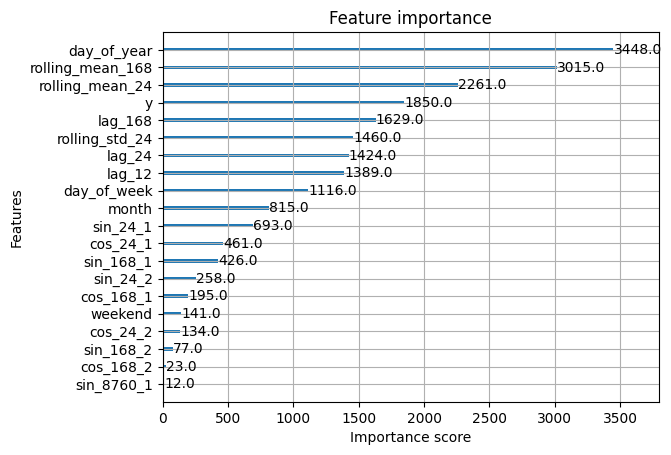

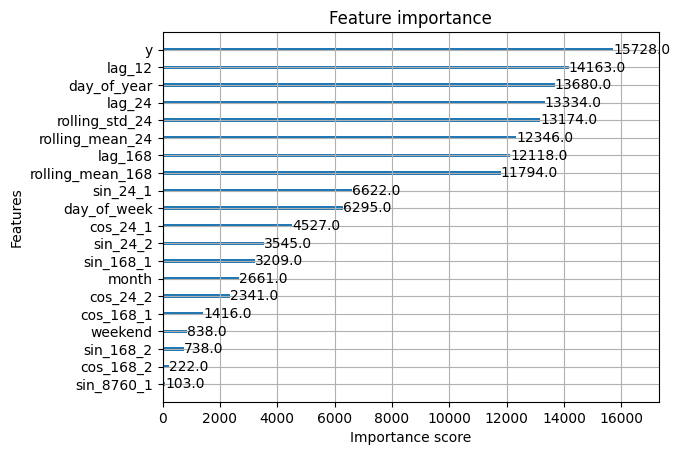

In [111]:
xgb.plot_importance(multi_model.models[-1], max_num_features=20)
xgb.plot_importance(multi_model.models[0], max_num_features=20)

In [59]:
best_params2

{'subsample': 0.7,
 'reg_lambda': 1,
 'reg_alpha': 0.001,
 'min_child_weight': 1,
 'max_depth': 7,
 'learning_rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 0.6}

In [82]:
len(val)

3671

In [93]:
display(pred_fixed[168:168+168])
test[168:168+168]

2024-06-08 00:00:00    0.852004
2024-06-08 01:00:00    0.829434
2024-06-08 02:00:00    0.819871
2024-06-08 03:00:00    0.800600
2024-06-08 04:00:00    0.817823
                         ...   
2024-06-14 19:00:00    1.049867
2024-06-14 20:00:00    1.033322
2024-06-14 21:00:00    0.991084
2024-06-14 22:00:00    0.928214
2024-06-14 23:00:00    0.866035
Freq: h, Length: 168, dtype: float32

y
2024-06-08 00:00:00  0.840702
2024-06-08 01:00:00  0.820987
2024-06-08 02:00:00  0.806712
2024-06-08 03:00:00  0.789169
2024-06-08 04:00:00  0.789940
...                       ...
2024-06-14 19:00:00  1.150405
2024-06-14 20:00:00  1.157909
2024-06-14 21:00:00  1.120859
2024-06-14 22:00:00  1.039214
2024-06-14 23:00:00  0.959861

[168 rows x 1 columns]

MAE:  0.03754269331693649 
MRSE: 0.05196898270361063 
MAPE : 0.035114094614982605


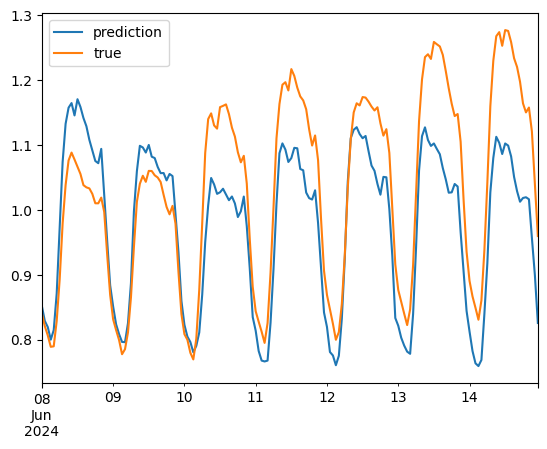

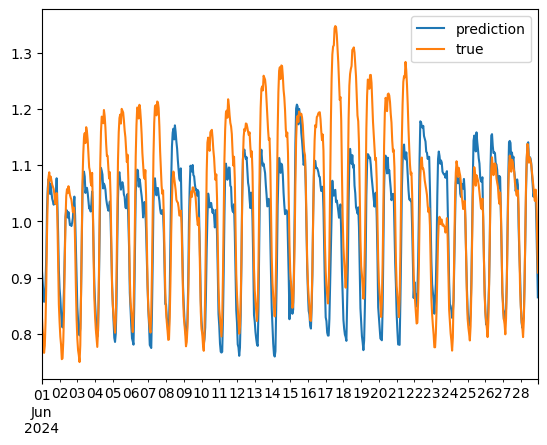

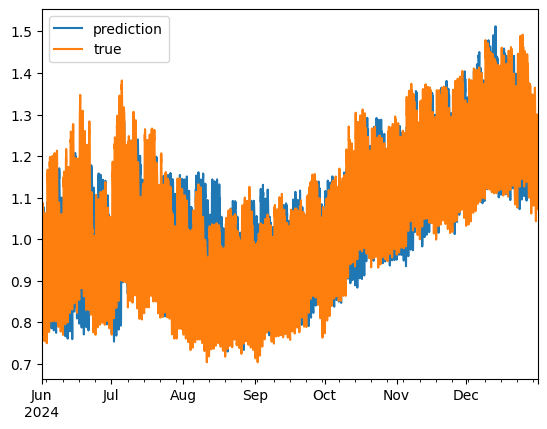

In [113]:
from sklearn.metrics import mean_absolute_percentage_error
y_pred = multi_model.predict(X_val)
print("MAE: ",mean_absolute_error(y_val,y_pred), '\nMRSE:', np.sqrt(mean_squared_error(y_val,y_pred)),'\nMAPE :',mean_absolute_percentage_error(y_val,y_pred))
pred_fixed=y_pred[::168].flatten()
pred_fixed=pd.Series(pred_fixed,index=test.index[:len(pred_fixed)])
ax=pred_fixed[168:168+168].plot()
test[168:168+168].plot(ax=ax)
plt.legend(['prediction','true'])
plt.figure()
ax=pred_fixed[:168*4].plot()
test[:168*4].plot(ax=ax)
plt.legend(['prediction','true'])
plt.figure()
ax=pred_fixed.plot()
test.plot(ax=ax)
plt.legend(['prediction','true'])


<Axes: >

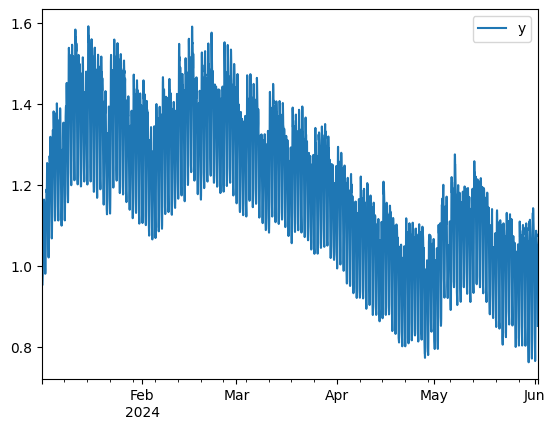

In [102]:
val.plot()

## MSTL

### testing bad seasonalities

<Axes: >

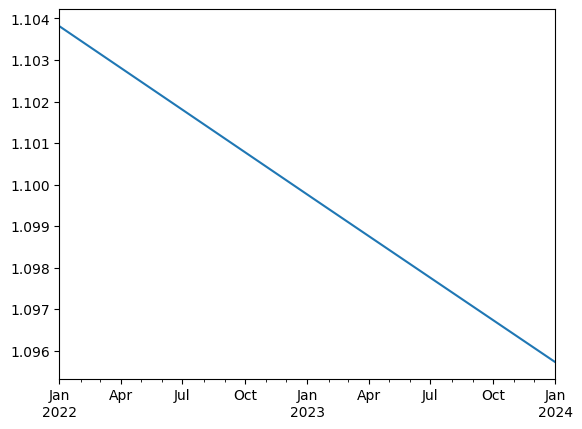

In [83]:
trend=decomposition.trend
trend.plot()

# X = np.arange(len(trend)).reshape(-1, 1)
# y = trend.values

# model = LinearRegression().fit(X, y)
# future_steps = 168  # 1 week ahead
# future_X = np.arange(len(trend), len(trend) + future_steps).reshape(-1, 1)
# trend_forecast = model.predict(future_X)
# plt.plot(trend_forecast)

In [23]:
class MSTLforecast:
    def __init__(self,series,seasons):
        decomp=MSTL(series,periods=seasons).fit()
        decomp.seasonal.columns=seasons
        self.decomp=decomp
        self.trend=decomp.trend
        self.resid=decomp.resid
        self.season=decomp.seasonal
        
        y=self.trend.values
        X=np.arange(len(y)).reshape(-1,1)
        window=24*60
        X_recent = X[-window:]
        y_recent = y[-window:]
        self.regression=Ridge().fit(X_recent, y_recent)
        
    # def season_forecast_from_history(self,season, period, start_idx, horizon):
    #     full = season.values
    #     idxs = (np.arange(start_idx, start_idx + horizon) % period)
    #     return full[-period:][idxs]
    def season_forecast_from_history(self, season, period, start_idx, horizon):
        season_array = season.values
        n_periods = 8  # or more
        slices = []
    
        for i in range(n_periods):
            end = len(season_array) - i * period
            start = end - period
            if start < 0:
                continue  # not enough data for full period
            slices.append(season_array[start:end])
    
        if not slices:
            # Fallback: use the last available season
            avg_season = season_array[-period:]
        else:
            recent_seasons = np.vstack(slices)
            avg_season = np.nanmean(recent_seasons, axis=0)
    
        idxs = (np.arange(start_idx, start_idx + horizon) % period)
        return avg_season[idxs]        
    def predict(self,horizon=168):
        pred_x=np.arange(len(self.trend),len(self.trend)+horizon).reshape(-1,1)
        pred_trend=self.regression.predict(pred_x)

        pred_season=[]
        for p in self.season.columns:
            season_part = self.season[p]
            start_idx = len(self.trend) % p
            season_forecast = self.season_forecast_from_history(season_part, p, start_idx, horizon)
            pred_season.append(season_forecast)
        pred_season = np.array(pred_season).sum(axis=0)
        pred=pred_season+pred_trend

        return pred
def forecast_step(hour, data, seasons, horizon):
    train = data[:hour]
    actual = data[hour:hour + horizon]
    
    if len(actual) < horizon:
        return None  # Skip this one

    model = MSTLforecast(train, seasons)
    forecast = model.predict(horizon=horizon)

    mae = mean_absolute_error(forecast, actual.values)
    mrse = mean_squared_error(forecast, actual.values)
    
    return mae, mrse, forecast, actual.values


In [24]:
data = pd.concat([tr, val])
pos = data.index.get_loc(val.index[0])
horizon = 168
seasons = [24,168,8760]

hours = list(range(pos, len(data), 168))
steps = (len(val) - 168 + 1) // 168

# Parallel Execution
results = []

forecast_step(pos,data,[12,24,8760],168)


(0.06258454377757529,
 0.0054332142602689665,
 array([0.94293825, 0.93752047, 0.95365414, 0.98809935, 1.02409155,
        1.05416252, 1.06239739, 1.0761576 , 1.07836489, 1.0707629 ,
        1.07367042, 1.08151362, 1.0826434 , 1.10589391, 1.14525067,
        1.14129395, 1.12573179, 1.11664909, 1.09844537, 1.05736299,
        1.01231614, 0.96300083, 0.92283976, 0.90335067, 0.89651451,
        0.90362114, 0.93382232, 0.9806805 , 1.02963669, 1.07964765,
        1.10945035, 1.13611989, 1.14026269, 1.13088612, 1.13064474,
        1.13096311, 1.13134021, 1.15204614, 1.19151507, 1.18793816,
        1.17010413, 1.15284041, 1.12775179, 1.07944919, 1.03169504,
        0.98327894, 0.94738085, 0.92640255, 0.92023553, 0.92519738,
        0.95449423, 1.00999274, 1.07736083, 1.15426033, 1.19230413,
        1.21948788, 1.21635576, 1.20066981, 1.21086944, 1.21372203,
        1.20615433, 1.2237802 , 1.2642228 , 1.25493995, 1.23183515,
        1.21171092, 1.18081627, 1.13337065, 1.08573945, 1.03978272,
  

In [25]:
with keep.running():
    try:
        with ProcessPoolExecutor() as executor:
            with tqdm(total=steps) as pbar:
                futures = [executor.submit(forecast_step, hour, data, seasons, horizon) for hour in hours]
                for f in futures:
                    res = f.result()
                    if res:
                        results.append(res)
                    pbar.update(1)
    except:
        notify('failure')
notify('finished')
# Unpack results
maes, mrses, all_preds, all_actuals = zip(*results)
mean_mae = np.mean(maes)
mean_mrse = np.mean(mrses)

print("Mean MAE:", mean_mae)

22it [10:57, 29.90s/it]                                                                                                                                                                                            


Mean MAE: 0.15280477137440795


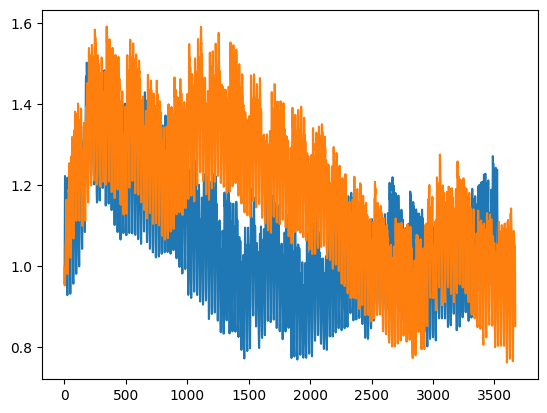

In [27]:
plt.plot(np.array(all_preds).flatten())
plt.plot(val.values.flatten())

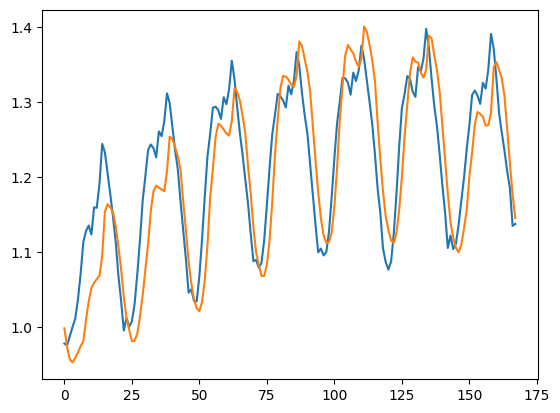

In [19]:
plt.plot(model.predict())
plt.plot(val.iloc[:168].values.flatten())

In [64]:
model.decomp.resid.mean()

8.59851073077678e-05

### daily and weekly, with XGBoost for rest

#### pretraining XGBoost on trend (one of two methods is incorrect, i am not sure which, probably first)

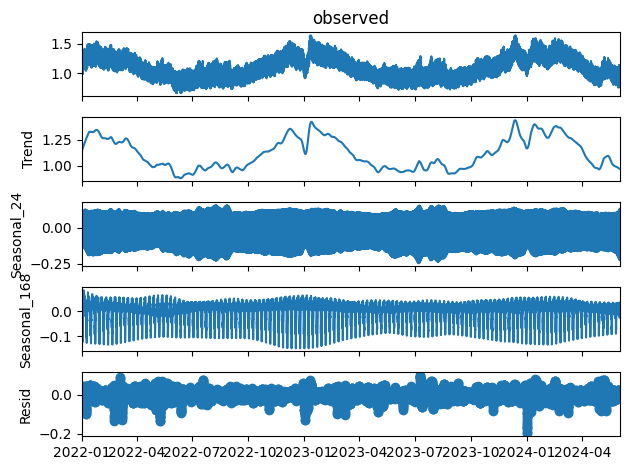

In [17]:
decomp=MSTL(pd.concat([tr,val]),periods=[24,168]).fit()
decomp.plot()
plt.show()

In [46]:
# def transform_data_trend(df):
#     def add_fourier_terms(df, period, order):
#         for k in range(1, order + 1):
#             df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * df.index.hour / period)
#             df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * df.index.hour / period)

#     ml_df = pd.DataFrame({'y': df.copy()})
    
#     ml_df['day_of_year']=ml_df.index.dayofyear
#     ml_df['month']=ml_df.index.month
    
#     ml_df['lag_12']=ml_df['y'].shift(12)
#     ml_df['lag_24']=ml_df['y'].shift(24)
#     ml_df['lag_168']=ml_df['y'].shift(168)
    
#     ml_df['rolling_mean_24']=ml_df['y'].shift(1).rolling(24).mean()
#     ml_df['rolling_mean_168']=ml_df['y'].shift(1).rolling(168).mean()
    
#     add_fourier_terms(ml_df,24*365,2)
    
#     targets = {
#         f'y_{h}': ml_df['y'].shift(-h) for h in range(1, 169)
#     }
    
#     targets_df = pd.concat(targets.values(), axis=1)
#     targets_df.columns=targets.keys()
#     ml_df=pd.concat([ml_df,targets_df],axis=1)
    
#     targ_col = [f'y_{h}' for h in range(1, 169)]
    
#     ml_df=ml_df.dropna()
        
#     X=ml_df.drop(targ_col,axis=1)
#     y=ml_df[targ_col]
    
#     return X,y
def transform_data_trend(df):
    df = df.copy()

    def add_fourier_terms(df, period, order):
        seconds = (df.index - df.index[0]).total_seconds()
        for k in range(1, order + 1):
            df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * seconds / (period * 3600))
            df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * seconds / (period * 3600))

    ml_df = pd.DataFrame({'y': df})
    ml_df['day_of_year'] = ml_df.index.dayofyear
    ml_df['month'] = ml_df.index.month

    for lag in [12, 24, 168]:
        ml_df[f'lag_{lag}'] = ml_df['y'].shift(lag)

    for window in [24, 168]:
        ml_df[f'rolling_mean_{window}'] = ml_df['y'].shift(1).rolling(window).mean()

    add_fourier_terms(ml_df, 24 * 365, 2)

    targets = {f'y_{h}': ml_df['y'].shift(-h) for h in range(1, 169)}
    targets_df = pd.concat(targets.values(), axis=1)
    targets_df.columns = targets.keys()

    ml_df = pd.concat([ml_df, targets_df], axis=1).dropna()
    ml_df = ml_df.iloc[:-168]  # drop last window used for targets

    X = ml_df.drop(targets_df.columns, axis=1)
    y = ml_df[targets_df.columns]

    return X, y


def build_xgboost(X,y): 

    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1,
        reg_lambda=1,
        random_state=42,
    )
    model=MultiOutputRegressor(model)
    return model.fit(X,y)
X_all,y_all=transform_data_trend(decomp.trend)

train_ind=X_all.index<'2024-01-01 01'
val_idx = (X_all.index >= '2024-01-01 01')

last_train = X_all.loc[train_ind].iloc[[-1]]
last_train_y = y_all.loc[train_ind].iloc[[-1]]

X_val = pd.concat([X_all.loc[val_idx], last_train]).sort_index()
y_val = pd.concat([y_all.loc[val_idx], last_train_y]).sort_index()

X = X_all.loc[train_ind].iloc[:-168]
y = y_all.loc[train_ind].iloc[:-168]

trend_model=build_xgboost(X,y)
notify('finished xgboost')

In [27]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import uniform, randint

# Grid for tuning
param_grid = {
    'estimator__n_estimators': randint(700, 850),  # ±10%
    'estimator__max_depth': randint(2, 5),         # Focus near 3
    'estimator__learning_rate': uniform(0.008, 0.011),  # Narrower band
    'estimator__subsample': uniform(0.9, 0.05),     # Around 0.92
    'estimator__colsample_bytree': uniform(0.9, 0.05)
}
base_model = XGBRegressor(objective='reg:squarederror', random_state=42)
multi_output = MultiOutputRegressor(base_model)

search=RandomizedSearchCV(multi_output,param_distributions=param_grid,n_iter=20, cv=3,scoring='neg_mean_absolute_error',n_jobs=10,verbose=2,random_state=42)
with keep.running():
    search.fit(X,y)
notify('finished search')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END estimator__colsample_bytree=0.9187270059423681, estimator__learning_rate=0.018457857370509076, estimator__max_depth=4, estimator__n_estimators=771, estimator__subsample=0.9299329242098519; total time= 4.0min
[CV] END estimator__colsample_bytree=0.9392587980696507, estimator__learning_rate=0.010196411603741958, estimator__max_depth=4, estimator__n_estimators=763, estimator__subsample=0.923338144662399; total time= 4.2min
[CV] END estimator__colsample_bytree=0.9283850163909996, estimator__learning_rate=0.008344446217011145, estimator__max_depth=3, estimator__n_estimators=743, estimator__subsample=0.9469749470782095; total time= 3.1min
[CV] END estimator__colsample_bytree=0.9148136752852042, estimator__learning_rate=0.009817936329693027, estimator__max_depth=2, estimator__n_estimators=770, estimator__subsample=0.9211700740353185; total time= 2.3min
[CV] END estimator__colsample_bytree=0.9355670976374325, estimator__lear

In [31]:
best_parameters2=search.best_params_
best_parameters2

{'estimator__colsample_bytree': 0.948281601653728,
 'estimator__learning_rate': 0.01689237082928107,
 'estimator__max_depth': 2,
 'estimator__n_estimators': 789,
 'estimator__subsample': 0.9048836057003192}

In [32]:
# with open('best_parameters.pkl', 'wb') as f:
#     pickle.dump(best_parameters2, f)
# with open('best_parameters2.pkl', 'rb') as f:
#     best_parameters = pickle.load(f)

In [110]:
val_pred=trend_model.predict(X_val)
print("MAE: ",mean_absolute_error(y_val,val_pred), '\nMRSE:', np.sqrt(mean_squared_error(y_val,val_pred)))


MAE:  0.022468695417046547 
MRSE: 0.03311381705976645


#### MLST

In [111]:
class MSTLforecast:
    def __init__(self,series,seasons,trend_model):
        decomp=MSTL(series,periods=seasons).fit()
        decomp.seasonal.columns=seasons
        self.decomp=decomp
        self.trend=decomp.trend
        self.resid=decomp.resid
        self.season=decomp.seasonal

        self.trend_model=trend_model
        self.trend_x,_=transform_data_trend(self.trend)
                
    def season_forecast_from_history(self,season, period, start_idx, horizon):
        full = season.values
        idxs = (np.arange(start_idx, start_idx + horizon) % period)
        return full[-period:][idxs]
        
    def predict(self,horizon=168):
        pred_trend=self.trend_model.predict(self.trend_x.iloc[[-1]]).flatten()

        pred_season=[]
        for p in self.season.columns:
            season_part = self.season[p]
            start_idx = len(self.trend) % p
            season_forecast = self.season_forecast_from_history(season_part, p, start_idx, horizon)
            pred_season.append(season_forecast)
        pred_season = np.array(pred_season).sum(axis=0)
        pred=pred_season+pred_trend

        return pred
def forecast_step(hour, data, seasons, horizon,trend_model):
    train = data[:hour]
    actual = data[hour:hour + horizon]
    
    if len(actual) < horizon:
        return None  # Skip this one

    model = MSTLforecast(train, seasons,trend_model)
    forecast = model.predict(horizon=horizon)

    mae = mean_absolute_error(forecast, actual.values)
    mrse = mean_squared_error(forecast, actual.values)

    residuals=pd.DataFrame(actual.values.flatten()-forecast,index=actual.index,columns=['y'])
    
    return mae, mrse, forecast, actual.values, residuals


In [113]:
data = pd.concat([tr, val])
pos = data.index.get_loc(val.index[0])
horizon = 168
seasons = [24,168]

hours = list(range(pos, len(data), 24))
steps = (len(val) - 168 + 1) // 24

# Parallel Execution
results = []



In [114]:
# with keep.running():
#     try:
#         with ProcessPoolExecutor() as executor:
#             with tqdm(total=steps) as pbar:
#                 futures = [executor.submit(forecast_step, hour, data, seasons, horizon,trend_model) for hour in hours]
#                 for f in futures:
#                     res = f.result()
#                     if res:
#                         results.append(res)
#                     pbar.update(1)
#     except:
#         notify('failure')
#         raise e
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(forecast_step, hour, data, seasons, horizon, trend_model) for hour in hours]
    with tqdm(total=len(futures)) as pbar:
        for f in as_completed(futures):
            try:
                res = f.result()
                if res:
                    results.append(res)
            except Exception as e:
                print("Error in forecast step:", e)
            pbar.update(1)
notify('finished')
# Unpack results
maes, mrses, all_preds, all_actuals,all_resid = zip(*results)
mean_mae = np.mean(maes)
mean_mrse = np.mean(mrses)
all_resid_df = pd.concat(all_resid)

print("Mean MAE:", mean_mae)

  0%|                                                   | 0/153 [00:00<?, ?it/s]IOStream.flush timed out
IOStream.flush timed out                       | 11/153 [00:55<08:11,  3.46s/it]
100%|█████████████████████████████████████████| 153/153 [12:04<00:00,  4.74s/it]


Mean MAE: 0.09260503297807432


#### Building resid

In [116]:
first_date=[x.index[0] for x in all_resid]
first_date

[Timestamp('2024-01-11 01:00:00'),
 Timestamp('2024-01-09 01:00:00'),
 Timestamp('2024-01-03 01:00:00'),
 Timestamp('2024-01-02 01:00:00'),
 Timestamp('2024-01-07 01:00:00'),
 Timestamp('2024-01-12 01:00:00'),
 Timestamp('2024-01-06 01:00:00'),
 Timestamp('2024-01-13 01:00:00'),
 Timestamp('2024-01-15 01:00:00'),
 Timestamp('2024-01-04 01:00:00'),
 Timestamp('2024-01-05 01:00:00'),
 Timestamp('2024-01-14 01:00:00'),
 Timestamp('2024-01-10 01:00:00'),
 Timestamp('2024-01-08 01:00:00'),
 Timestamp('2024-01-16 01:00:00'),
 Timestamp('2024-01-01 01:00:00'),
 Timestamp('2024-01-18 01:00:00'),
 Timestamp('2024-01-29 01:00:00'),
 Timestamp('2024-01-25 01:00:00'),
 Timestamp('2024-01-19 01:00:00'),
 Timestamp('2024-01-23 01:00:00'),
 Timestamp('2024-01-24 01:00:00'),
 Timestamp('2024-01-21 01:00:00'),
 Timestamp('2024-01-17 01:00:00'),
 Timestamp('2024-01-30 01:00:00'),
 Timestamp('2024-01-26 01:00:00'),
 Timestamp('2024-01-20 01:00:00'),
 Timestamp('2024-01-22 01:00:00'),
 Timestamp('2024-01-

In [178]:
def transform_data_residual(df):
    df = pd.Series(df) if not isinstance(df, pd.Series) else df
    df = df.copy()
    
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Input series must have a DatetimeIndex")


    def add_fourier_terms(df, period, order):
        seconds = (df.index - df.index[0]).total_seconds()
        for k in range(1, order + 1):
            df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * seconds / (period * 3600))
            df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * seconds / (period * 3600))
    
    ml_df = pd.DataFrame({'y': df})

    # Time-based features
    ml_df['dayofweek'] = ml_df.index.dayofweek
    ml_df['is_weekend'] = ml_df.index.dayofweek >= 5
    ml_df['day'] = ml_df.index.day
    ml_df['month'] = ml_df.index.month

    # Lag features (local structure)
    for lag in [1, 2, 12, 24, 48]:
        ml_df[f'lag_{lag}'] = ml_df['y'].shift(lag)

    # Rolling features (local context)
    for window in [6, 12, 24]:
        ml_df[f'rolling_mean_{window}'] = ml_df['y'].shift(1).rolling(window).mean()

    # Seasonal Fourier terms (weaker)
    add_fourier_terms(ml_df, 24 * 7, 2)  # weekly cycle
    add_fourier_terms(ml_df, 24, 2)      # daily cycle

    ml_df = ml_df.dropna()

    return ml_df.iloc[[-1]]
    
class MSTLforecast_resid:
    def __init__(self,series,seasons,trend_model=None,resid_model=None):
        decomp=MSTL(series,periods=seasons).fit()
        decomp.seasonal.columns=seasons
        
        self.series=series
        self.decomp=decomp
        self.trend=decomp.trend
        self.resid=decomp.resid
        self.season=decomp.seasonal

        self.trend_model=trend_model
        self.trend_x,_=transform_data_trend(self.trend)

        self.resid_model=resid_model
        series=series.squeeze()
        self.resid_x=transform_data_residual(series)
    def train_trend
    def season_forecast_from_history(self,season, period, start_idx, horizon):
        full = season.values
        idxs = (np.arange(start_idx, start_idx + horizon) % period)
        return full[-period:][idxs]
        
    def predict(self,horizon=168):
        pred_trend=self.trend_model.predict(self.trend_x.iloc[[-1]]).flatten()

        pred_resid=self.resid_model.predict(self.resid_x).flatten()
        
        pred_season=[]
        for p in self.season.columns:
            season_part = self.season[p]
            start_idx = len(self.trend) % p
            season_forecast = self.season_forecast_from_history(season_part, p, start_idx, horizon)
            pred_season.append(season_forecast)
        pred_season = np.array(pred_season).sum(axis=0)
        pred=pred_season+pred_trend+pred_resid

        return pred
        
def forecast_step_resid(hour, data, seasons, horizon,trend_model,resid_model):
    train = data[:hour]
    actual = data[hour:hour + horizon]
    
    if len(actual) < horizon:
        return None  # Skip this one

    model = MSTLforecast_resid(train, seasons,trend_model,resid_model)
    forecast = model.predict(horizon=horizon)

    mae = mean_absolute_error(forecast, actual.values)
    mrse = mean_squared_error(forecast, actual.values)

    residuals=pd.DataFrame(actual.values.flatten()-forecast,index=actual.index,columns=['y'])
    
    return mae, mrse, forecast, actual.values, residuals


In [ ]:
X_rows = []
y_rows = []

for resid, forecast_start in zip(all_resid, first_date):
    # Get training data up to (but not including) forecast start
    history = data['y'][:forecast_start]

    # Transform it
    X_input = transform_data_residual(history)

    # Last row is feature input for this forecast
    X_rows.append(X_input)

    # Flatten residual to 1D vector (168,)
    y_resid_vector = resid['y'].values  # shape (168,)
    y_rows.append(y_resid_vector)
X_resid = pd.concat(X_rows)
y_resid = np.stack(y_rows)
X_resid

In [168]:

resid_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
)
resid_model.fit(X_resid, y_resid)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [169]:
# collectiong residual of the training
data = pd.concat([tr,val])
pos = data.index.get_loc(val.index[0])
horizon = 168
seasons = [24,168]

hours = list(range(pos, len(data), 24))
steps = (len(val) - 168 + 1) // 24

# Parallel Execution
results = []



In [179]:
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(forecast_step_resid, hour, data, seasons, horizon, trend_model,resid_model) for hour in hours]
    with tqdm(total=len(futures)) as pbar:
        for f in as_completed(futures):
            try:
                res = f.result()
                if res:
                    results.append(res)
            except Exception as e:
                print("Error in forecast step:", e)
            pbar.update(1)
notify('finished')
# Unpack results
maes, mrses, all_preds, all_actuals,all_resid = zip(*results)
mean_mae = np.mean(maes)
mean_mrse = np.mean(mrses)
all_resid_df = pd.concat(all_resid)

print("Mean MAE:", mean_mae)


%|                                                   | 0/153 [00:00<?, ?it/s]
%|▎                                        | 1/153 [01:21<3:25:43, 81.21s/it]
%|▌                                        | 2/153 [01:26<1:28:21, 35.11s/it]
%|▊                                          | 3/153 [01:29<53:14, 21.29s/it]
IOStream.flush timed out
%|█                                          | 4/153 [01:53<42:16, 17.02s/it]
IOStream.flush timed out                     | 5/153 [02:02<43:51, 17.78s/it]

%|█▋                                         | 6/153 [02:30<48:28, 19.79s/it]
%|█▉                                         | 7/153 [02:33<41:01, 16.86s/it]
%|██▏                                        | 8/153 [02:46<36:19, 15.03s/it]
%|██▌                                        | 9/153 [02:52<30:29, 12.70s/it]
%|██▋                                       | 10/153 [02:54<21:41,  9.10s/it]
%|███                                       | 11/153 [03:03<21:01,  8.89s/it]
%|███▎                               

Mean MAE: 0.034493241116080334


In [185]:
print('MAE:',np.mean(maes),'\nRMSE: ',np.mean(mrses))

MAE: 0.034493241116080334 
RMSE:  0.002207549529472183


In [180]:
# with open('mstl_resid_result.pkl', 'wb') as f:
#     pickle.dump(results, f)
# with open('xgb_multioutput_model.pkl', 'rb') as f:
#     models = pickle.load(f)

In [181]:
pred_fixed=np.array(all_actuals[::7]).flatten()
len(pred_fixed)

3528

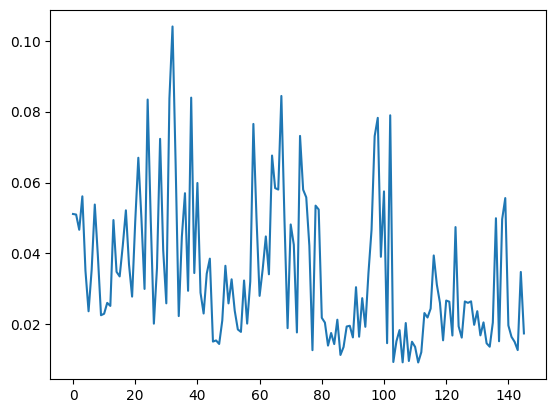

In [189]:
plt.plot(maes)


### Optimizion and building pipeline

In [34]:
best_parameters2

{'estimator__colsample_bytree': 0.948281601653728,
 'estimator__learning_rate': 0.01689237082928107,
 'estimator__max_depth': 2,
 'estimator__n_estimators': 789,
 'estimator__subsample': 0.9048836057003192}

In [19]:
class MSTLforecast_resid:
    def __init__(self,train,validation,seasons,trend_model=None,resid_model=None,trend_model_path='',resid_model_path='',horizon=168):
        self.train=train
        self.validation=validation
        self.data=pd.concat([train,validation])
        self.seasons=seasons
        self.horizon=horizon

        if trend_model is not None:
            self.trend_model=trend_model

        elif os.path.exists(trend_model_path):
            print("Loading saved trend model...")
            with open(trend_model_path, "rb") as f:
                self.trend_model = pickle.load(f)
        else:
            decomp_train=MSTL(train,periods=seasons).fit()
            X,y=self.transform_data_trend(decomp_train.trend)                        
            
            self.trend_model=self.build_xgboost(X,y)
            with open(trend_model_path, "wb") as f:
                pickle.dump(self.trend_model, f)

            notify('finished_trend')
            print('finished trend model')

        if resid_model is not None:
            self.resid_model=resid_model
        elif os.path.exists(resid_model_path):
            print("Loading saved resid model...")
            with open(resid_model_path, "rb") as f:
                self.resid_model = pickle.load(f)
        else:
            data = pd.concat([train, validation])
            pos = data.index.get_loc(validation.index[0])
            
            hours = list(range(pos, len(data), 24))
            steps = (len(validation) - 168 + 1) // 24
            
            # Parallel Execution
            results = []

            with ThreadPoolExecutor() as executor:
                futures = [executor.submit(self.make_forecast_without_resid,  data,hour) for hour in hours]
                with tqdm(total=len(futures)) as pbar:
                    for f in as_completed(futures):
                        try:
                            res = f.result()
                            if res:
                                results.append(res)
                        except Exception as e:
                            print("Error in forecast step:", e)
                        pbar.update(1)
            # Unpack results
            all_preds, all_actuals,all_resid = zip(*results)
            
            first_date=[x.index[0] for x in all_resid]

            X_rows = []
            y_rows = []
            
            for resid, forecast_start in zip(all_resid, first_date):
                # Get training data up to (but not including) forecast start
                history = data['y'][:forecast_start]
            
                # Transform it
                X_input = self.transform_data_residual(history)
            
                # Last row is feature input for this forecast
                X_rows.append(X_input)
            
                # Flatten residual to 1D vector (168,)
                y_resid_vector = resid['y'].values  # shape (168,)
                y_rows.append(y_resid_vector)
            X_resid = pd.concat(X_rows)
            y_resid = np.stack(y_rows)

            self.resid_model=self.build_xgboost(X_resid,y_resid)
            
            with open(resid_model_path, "wb") as f:
                pickle.dump(self.resid_model, f)
            notify('finished_resid')
            print('finished residual model')
        
    def transform_data_trend(self,df):
        df = df.copy()
    
        def add_fourier_terms(df, period, order):
            seconds = (df.index - df.index[0]).total_seconds()
            for k in range(1, order + 1):
                df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * seconds / (period * 3600))
                df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * seconds / (period * 3600))
    
        ml_df = pd.DataFrame({'y': df},index=df.index)
        ml_df['day_of_year'] = ml_df.index.dayofyear
        ml_df['month'] = ml_df.index.month
    
        for lag in [12, 24, 168]:
            ml_df[f'lag_{lag}'] = ml_df['y'].shift(lag)
    
        for window in [24, 168]:
            ml_df[f'rolling_mean_{window}'] = ml_df['y'].shift(1).rolling(window).mean()
    
        add_fourier_terms(ml_df, 24 * 365, 2) #year
        add_fourier_terms(ml_df, 8760/2, 2) #half-year
    
    
        targets = {f'y_{h}': ml_df['y'].shift(-h) for h in range(1, 169)}
        targets_df = pd.concat(targets.values(), axis=1)
        targets_df.columns = targets.keys()
    
        ml_df = pd.concat([ml_df, targets_df], axis=1).dropna()
        # ml_df = ml_df.iloc[:-168]  # drop last window used for targets, maybe consider later, dronpa takes care of it for now
        X = ml_df.drop(targets_df.columns, axis=1)
        y = ml_df[targets_df.columns]
    
        return X, y
    def transform_data_residual(self,df):
        df = pd.Series(df) if not isinstance(df, pd.Series) else df
        df = df.copy()
        
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("Input series must have a DatetimeIndex")
    
    
        def add_fourier_terms(df, period, order):
            seconds = (df.index - df.index[0]).total_seconds()
            for k in range(1, order + 1):
                df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * seconds / (period * 3600))
                df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * seconds / (period * 3600))
        
        ml_df = pd.DataFrame({'y': df})
    
        # Time-based features
        ml_df['dayofweek'] = ml_df.index.dayofweek
        ml_df['is_weekend'] = ml_df.index.dayofweek >= 5
        ml_df['day'] = ml_df.index.day
        ml_df['month'] = ml_df.index.month
    
        # Lag features (local structure)
        for lag in [1, 2, 12, 24, 48]:
            ml_df[f'lag_{lag}'] = ml_df['y'].shift(lag)
    
        # Rolling features (local context)
        for window in [6, 12, 24]:
            ml_df[f'rolling_mean_{window}'] = ml_df['y'].shift(1).rolling(window).mean()
    
        # Seasonal Fourier terms (weaker)
        add_fourier_terms(ml_df, 24 * 7, 2)  # weekly cycle
        add_fourier_terms(ml_df, 24, 2)      # daily cycle
    
        ml_df = ml_df.dropna()
    
        return ml_df.iloc[[-1]]

    def build_xgboost(self,X,y): 
        model = xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1,
            reg_lambda=1,
            random_state=42

            # n_estimators=789,
            # learning_rate=0.01689237082928107,
            # max_depth=2,
            # subsample=0.9048836057003192,
            # colsample_bytree=0.948281601653728,
            # reg_alpha=1,
            # reg_lambda=1,
            # random_state=42,
        )
        model=MultiOutputRegressor(model)
        return model.fit(X,y)

    def season_forecast_from_history(self,season, period, start_idx):
        full = season.values
        idxs = (np.arange(start_idx, start_idx + self.horizon) % period)
        return full[-period:][idxs]
    def predict_without_resid(self,series):
        decomp=MSTL(series,periods=self.seasons).fit()
        decomp.seasonal.columns=self.seasons
        trend_x,_=self.transform_data_trend(decomp.trend)
        pred_trend=self.trend_model.predict(trend_x.iloc[[-1]]).flatten()
        
        pred_season=[]
        for p in decomp.seasonal.columns:
            season_part = decomp.seasonal[p]
            start_idx = len(decomp.trend) % p
            season_forecast = self.season_forecast_from_history(season_part, p, start_idx)
            pred_season.append(season_forecast)
        pred_season = np.array(pred_season).sum(axis=0)
        pred=pred_season+pred_trend

        return pred
    def make_forecast_without_resid(self,data,hour):
        train = data[:hour]
        actual = data[hour:hour + self.horizon]
        
        if len(actual) < self.horizon:
            return None  # Skip this one
    
        forecast=self.predict_without_resid(train)
    
        residuals=pd.DataFrame(actual.values.flatten()-forecast,index=actual.index,columns=['y'])
        
        return forecast, actual, residuals
    def predict(self,series):
        decomp=MSTL(series,periods=self.seasons).fit()
        decomp.seasonal.columns=self.seasons
        trend_x,_=self.transform_data_trend(decomp.trend)
        pred_trend=self.trend_model.predict(trend_x.iloc[[-1]]).flatten()
        
        pred_resid=self.resid_model.predict(self.transform_data_residual(series)).flatten()

        pred_season=[]
        for p in decomp.seasonal.columns:
            season_part = decomp.seasonal[p]
            start_idx = len(decomp.trend) % p
            season_forecast = self.season_forecast_from_history(season_part, p, start_idx)
            pred_season.append(season_forecast)
        pred_season = np.array(pred_season).sum(axis=0)
        pred=pred_season+pred_trend+pred_resid

        return pred


In [21]:
with keep.running():
    final_model=MSTLforecast_resid(tr,val,[24,168],trend_model_path='trend2_inner.pkl',resid_model_path='resid2_inner.pkl')

finished trend model


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [11:54<00:00,  4.67s/it]


finished residual model


In [23]:
data = pd.concat([tr, val])
pos = data.index.get_loc(val.index[0])

hours = list(range(pos, len(data)-final_model.horizon+1, 24))
steps = (len(val) - final_model.horizon + 1) // 24

# Parallel Execution
results = []
def get_pred_actual(final_model,data,hour):
    prediction=final_model.predict(data[:hour].squeeze()).flatten()
    actual=data.iloc[hour:hour+final_model.horizon].values.flatten()
    return prediction, actual

get_pred_actual(final_model,data,hours[1])

(array([1.09079361, 1.078061  , 1.07704862, 1.10200657, 1.12716067,
        1.17375077, 1.22468766, 1.26783012, 1.29624379, 1.30447416,
        1.27681093, 1.29120398, 1.29642876, 1.31808757, 1.35345501,
        1.35325077, 1.33931552, 1.30493564, 1.31275701, 1.31416752,
        1.27317975, 1.22908642, 1.1736429 , 1.10697192, 1.08739268,
        1.06827228, 1.05148826, 1.02622749, 1.03528311, 1.08582862,
        1.16548314, 1.21663043, 1.26280184, 1.27890386, 1.24265157,
        1.25345604, 1.2617257 , 1.29134933, 1.33042425, 1.33967761,
        1.32414909, 1.29221994, 1.29684509, 1.29847825, 1.25476979,
        1.21002564, 1.15362681, 1.09460969, 1.07042613, 1.05357617,
        1.04245517, 1.03612601, 1.05986736, 1.09814145, 1.16603453,
        1.20481655, 1.24468614, 1.26061645, 1.23346326, 1.24321365,
        1.24196465, 1.26119756, 1.30615983, 1.32883848, 1.3193465 ,
        1.29759903, 1.28467303, 1.27432982, 1.23359951, 1.18836564,
        1.14200795, 1.08177678, 1.06428591, 1.05

In [24]:
with keep.running():
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(get_pred_actual,final_model,  data,hour) for hour in hours]
        with tqdm(total=len(futures)) as pbar:
            for f in as_completed(futures):
                try:
                    res = f.result()
                    if res:
                        results.append(res)
                except Exception as e:
                    print("Error in forecast step:", e)
                pbar.update(1)
notify('finished')
predictions,actuals=zip(*results)

predictions,actuals=np.array(predictions),np.array(actuals)
print("MAE: ",mean_absolute_error(actuals,predictions), '\nMRSE:', np.sqrt(mean_squared_error(actuals,predictions)))


IOStream.flush timed out                                                                                                                                                                   | 0/146 [00:00<?, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [12:45<00:00,  5.24s/it]


MAE:  0.0487013397744701 
MRSE: 0.06348612781413186


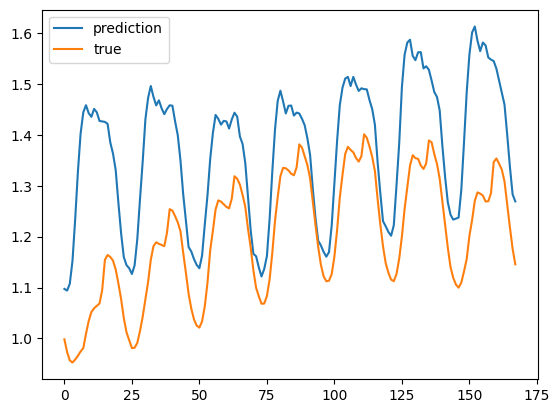

In [31]:
fixed_pred=predictions[::7].flatten()
plt.plot(fixed_pred[:24*7])
plt.plot(val.values.flatten()[:24*7])
plt.legend(['prediction','true'])

In [ ]:
with keep.running():
    final_model=MSTLforecast_resid(data,test,seasons=[24,168])


In [ ]:
final_model.trend_model

## SARIMA + XGBoost

### SARIMA

In [9]:
def make_sarima(tr):
    pre_model=SARIMAX(tr, 
            order=(2, 0, 1),
            seasonal_order=(2, 0, 2, 24),
            enforce_stationarity=False, 
            enforce_invertibility=False
            )
    model=pre_model.fit(maxiter=1000, disp=False)
    return model
def make_sarima_prediction(data,start,horizon=168):
    try:
        model=make_sarima(data.iloc[max(start-4380,0):start])
        prediction=model.forecast(horizon).iloc[-horizon:]
        
        forecast_index = data.index[start:start+horizon]
        prediction = prediction.set_axis(forecast_index)
    
        actual_one=data[start:start+horizon]
    
        return prediction, actual_one
    except Exception as e:
        print(f"Error at start={start}: {e}")
        return None

In [12]:
pos=tr.index.get_loc(tr.index[4380])
hours=range(pos,len(tr)-168,24)

results=[]

In [13]:
with keep.running():
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(make_sarima_prediction, tr, start) for start in hours]
        with tqdm(total=len(futures)) as pbar:
            for f in as_completed(futures):
                try:
                    res = f.result()
                    if res:
                        results.append(res)
                except Exception as e:
                    print("Error in forecast step:", e)
                pbar.update(1)
notify('finished')

/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals   | 27/541 [04:03<1:41:43, 11.87s/it]
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals     | 61/541 [07:42<44:07,  5.51s/it]
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals     | 75/541 [09:32<57:07,  7.35s/it]
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals  | 128/

In [9]:
# with open('sarima_resid_result.pkl', 'wb') as f:
#     pickle.dump(results, f)
# with open('sarima_resid_result.pkl', 'rb') as f:
#     results = pickle.load(f)

In [10]:
predictions,actuals=zip(*results)
actuals=[x.squeeze() for x in actuals]
actuals[0]

2022-07-03 12:00:00    0.943736
2022-07-03 13:00:00    0.940698
2022-07-03 14:00:00    0.931439
2022-07-03 15:00:00    0.931922
2022-07-03 16:00:00    0.934492
                         ...   
2022-07-10 07:00:00    0.917284
2022-07-10 08:00:00    0.987094
2022-07-10 09:00:00    1.032691
2022-07-10 10:00:00    1.052330
2022-07-10 11:00:00    1.047229
Freq: h, Name: y, Length: 168, dtype: float64

### XGBoost

In [11]:
def transform_data_residual(df):
    df = pd.Series(df.squeeze())
    df = df.copy()
    
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Input series must have a DatetimeIndex")


    def add_fourier_terms(df, period, order):
        seconds = (df.index - df.index[0]).total_seconds()
        for k in range(1, order + 1):
            df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * seconds / (period * 3600))
            df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * seconds / (period * 3600))
    
    ml_df = pd.DataFrame({'y': df})

    # Time-based features
    ml_df['day_of_week']=ml_df.index.dayofweek
    ml_df['day_of_year']=ml_df.index.dayofyear
    ml_df['month']=ml_df.index.month
    ml_df['weekend']=ml_df['day_of_week']>=5
    
    
    ml_df['rolling_mean_24']=ml_df['y'].shift(1).rolling(24).mean()
    ml_df['rolling_std_24']=ml_df['y'].shift(1).rolling(24).std()
    ml_df['rolling_mean_168']=ml_df['y'].shift(1).rolling(168).mean()
    

    # Lag features (local structure)
    for lag in [1, 2, 12, 24, 48]:
        ml_df[f'lag_{lag}'] = ml_df['y'].shift(lag)

    # Rolling features (local context)
    for window in [6, 12, 24]:
        ml_df[f'rolling_mean_{window}'] = ml_df['y'].shift(1).rolling(window).mean()

    # Seasonal Fourier terms (weaker)
    add_fourier_terms(ml_df, 24 * 7, 2)  # weekly cycle
    add_fourier_terms(ml_df, 24, 2)      # daily cycle

    ml_df = ml_df.dropna()

    return ml_df.iloc[[-1]]

def forecast_step_resid(data, hour, resid_model, horizon=168):
    print('started')
    train = data[:hour]
    
    print('sarima_pred')

    sarima_prediction,actual=make_sarima_prediction(data,hour,horizon)
    if len(actual) < horizon:
        return None  # Skip this one

    print('residual_pred')
    residual_x=transform_data_residual(train)
    residual_prediction=resid_model.predict(residual_x).flatten()
    residual_prediction = pd.Series(residual_prediction, index=actual.index)
    forecast=sarima_prediction+residual_prediction
    
    residuals=pd.DataFrame(actual.values.flatten() - forecast.values,
                                 index=actual.index, columns=["y"])

    print('finished')
    return forecast, actual, residuals



In [12]:
residuals=[actuals[x]-predictions[x] for x in range(len(actuals))]
first_date=[x.index[0] for x in residuals]
X_rows = []
y_rows = []
data=tr

for resid, forecast_start in zip(residuals, first_date):
    # Get training data up to (but not including) forecast start
    history = data['y'][:forecast_start]
    
    if forecast_start not in data.index:
        continue  # or raise a warning

    # Transform it
    X_input = transform_data_residual(history)

    # Last row is feature input for this forecast
    X_rows.append(X_input)

    # Flatten residual to 1D vector (168,)
    y_resid_vector = resid.values  # shape (168,)
    y_rows.append(y_resid_vector)
X_resid = pd.concat(X_rows)
y_resid = np.stack(y_rows)
len(X_resid)

541

In [13]:
resid_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
)
resid_model.fit(X_resid, y_resid)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [14]:
data=pd.concat([tr,val])
pos=data.index.get_loc(val.index[0])
hours=range(pos,len(data)-168,24)

results=[]

In [17]:
result=forecast_step_resid(data,hours[0],resid_model)
result

started
sarima_pred
residual_pred
finished


(2024-01-01 01:00:00    1.003059
 2024-01-01 02:00:00    0.993463
 2024-01-01 03:00:00    1.000082
 2024-01-01 04:00:00    1.008511
 2024-01-01 05:00:00    1.054730
                          ...   
 2024-01-07 20:00:00    1.548574
 2024-01-07 21:00:00    1.514817
 2024-01-07 22:00:00    1.437103
 2024-01-07 23:00:00    1.362995
 2024-01-08 00:00:00    1.345465
 Freq: h, Length: 168, dtype: float64,
                             y
 2024-01-01 01:00:00  0.998352
 2024-01-01 02:00:00  0.973249
 2024-01-01 03:00:00  0.956802
 2024-01-01 04:00:00  0.952784
 2024-01-01 05:00:00  0.958611
 ...                       ...
 2024-01-07 20:00:00  1.308577
 2024-01-07 21:00:00  1.262835
 2024-01-07 22:00:00  1.218472
 2024-01-07 23:00:00  1.176403
 2024-01-08 00:00:00  1.145602
 
 [168 rows x 1 columns],
                             y
 2024-01-01 01:00:00 -0.004707
 2024-01-01 02:00:00 -0.020214
 2024-01-01 03:00:00 -0.043280
 2024-01-01 04:00:00 -0.055727
 2024-01-01 05:00:00 -0.096119
 ...         

In [18]:
with keep.running():
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(forecast_step_resid, data, start,resid_model,168) for start in hours]
        with tqdm(total=len(futures)) as pbar:
            for f in as_completed(futures):
                try:
                    res = f.result()
                    if res:
                        results.append(res)
                except Exception as e:
                    print("Error in forecast step:", e)
                    notify('failed hybrid')
                pbar.update(1)
notify('finished')

started
sarima_pred
started
sarima_pred
started
sarima_pred
started
sarima_pred
started
sarima_pred
started
sarima_pred
started
sarima_pred
started
sarima_pred
started
sarima_pred
started
sarima_pred
started
sarima_pred
started
sarima_pred
started
sarima_pred
started
sarima_pred
started
sarima_pred
started
sarima_pred


  0%|                                                   | 0/146 [00:00<?, ?it/s]

residual_pred
residual_pred
residual_pred


  1%|▎                                      | 1/146 [09:23<22:41:06, 563.22s/it]

finished
started
sarima_pred
residual_pred
residual_pred
residual_pred
residual_pred
residual_pred


  1%|▌                                      | 2/146 [10:35<10:58:26, 274.35s/it]

finished
started
sarima_pred


  2%|▊                                       | 3/146 [10:36<5:56:44, 149.68s/it]

finished
started
sarima_pred


  3%|█                                        | 4/146 [10:44<3:41:55, 93.77s/it]

finished
started
sarima_pred
finished
started
sarima_pred


  3%|█▍                                       | 5/146 [10:45<2:21:08, 60.06s/it]

finished
started
sarima_pred


  4%|█▋                                       | 6/146 [10:45<1:33:00, 39.86s/it]

residual_pred
residual_pred


  5%|█▉                                       | 7/146 [10:59<1:12:57, 31.50s/it]

finished
started
sarima_pred
residual_pred
finished

  5%|██▎                                        | 8/146 [11:10<56:44, 24.67s/it]


started
sarima_pred
residual_pred
residual_pred
residual_pred
residual_pred
finished
started
sarima_pred


  7%|██▋                                     | 10/146 [12:18<1:01:47, 27.26s/it]

finished
started
sarima_pred


  8%|███▏                                      | 11/146 [12:19<42:58, 19.10s/it]

finished
started
sarima_pred
finished
started
sarima_pred


  8%|███▍                                      | 12/146 [12:30<37:24, 16.75s/it]

residual_pred
finished
started
sarima_pred


 10%|████                                      | 14/146 [13:09<37:34, 17.08s/it]

finished
started
sarima_pred


 10%|████▎                                     | 15/146 [13:17<31:28, 14.41s/it]

finished
started
sarima_pred


 11%|████▌                                     | 16/146 [14:04<52:34, 24.27s/it]

finished
started
sarima_pred
residual_pred
residual_pred
finished
started
sarima_pred


 12%|████▌                                  | 17/146 [19:41<4:13:50, 118.06s/it]

residual_pred


 12%|████▊                                  | 18/146 [21:13<3:55:06, 110.21s/it]

finished
started
sarima_pred
residual_pred
residual_pred
residual_pred


 13%|█████                                  | 19/146 [22:30<3:32:13, 100.26s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 14%|█████▍                                  | 20/146 [22:38<2:32:47, 72.76s/it]

finished
started
sarima_pred
residual_pred


 14%|█████▊                                  | 21/146 [22:41<1:47:51, 51.77s/it]

finished
started
sarima_pred


 15%|██████                                  | 22/146 [22:47<1:18:47, 38.12s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 16%|██████▎                                 | 23/146 [23:52<1:34:17, 46.00s/it]

finished
started
sarima_pred


 16%|██████▌                                 | 24/146 [23:52<1:05:42, 32.31s/it]

finished
started
sarima_pred


 17%|███████▏                                  | 25/146 [23:58<49:17, 24.44s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 18%|███████▍                                  | 26/146 [24:35<56:25, 28.21s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 18%|███████▊                                  | 27/146 [24:43<43:32, 21.95s/it]

finished
started
sarima_pred
residual_pred


 19%|████████                                  | 28/146 [25:28<56:59, 28.98s/it]

finished
started
sarima_pred


 20%|████████▎                                 | 29/146 [25:35<43:35, 22.35s/it]

finished
started
sarima_pred


 21%|████████▋                                 | 30/146 [25:53<40:58, 21.19s/it]

finished
started
sarima_pred


 21%|████████▉                                 | 31/146 [26:08<37:03, 19.33s/it]

finished
started
sarima_pred


 22%|█████████▏                                | 32/146 [26:29<37:36, 19.79s/it]

finished
started
sarima_pred
residual_pred
residual_pred
residual_pred
residual_pred
finished
started
sarima_pred


 23%|████████▊                              | 33/146 [34:06<4:44:12, 150.91s/it]

finished
started
sarima_pred


 23%|█████████                              | 34/146 [34:18<3:23:40, 109.11s/it]

residual_pred
residual_pred


 24%|█████████▌                              | 35/146 [34:49<2:38:42, 85.79s/it]

finished
started
sarima_pred


 25%|█████████▊                              | 36/146 [35:10<2:01:30, 66.28s/it]

finished
started
sarima_pred
residual_pred
residual_pred
residual_pred
residual_pred


 25%|██████████▏                             | 37/146 [36:02<1:52:52, 62.13s/it]

finished
started
sarima_pred


 26%|██████████▍                             | 38/146 [36:06<1:20:05, 44.49s/it]

finished
started
sarima_pred
residual_pred
residual_pred
finished

 27%|██████████▋                             | 39/146 [36:31<1:08:57, 38.66s/it]


started
sarima_pred


 27%|███████████▌                              | 40/146 [36:43<54:21, 30.77s/it]

finished
started
sarima_pred
finished
started
sarima_pred


 29%|████████████                              | 42/146 [37:02<34:35, 19.96s/it]

finished
started
sarima_pred
residual_pred


 29%|████████████▎                             | 43/146 [37:11<28:49, 16.79s/it]

finished
started
sarima_pred
finished
started
sarima_pred


 30%|████████████▋                             | 44/146 [37:40<34:39, 20.39s/it]

residual_pred


 31%|████████████▉                             | 45/146 [38:31<49:31, 29.43s/it]

finished
started
sarima_pred
residual_pred


 32%|████████████▌                           | 46/146 [39:34<1:06:11, 39.71s/it]

finished
started
sarima_pred


 32%|████████████▉                           | 47/146 [40:16<1:06:42, 40.43s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 33%|█████████████▏                          | 48/146 [43:17<2:14:31, 82.36s/it]

finished
started
sarima_pred


 34%|█████████████▍                          | 49/146 [44:14<2:01:16, 75.01s/it]

finished
started
sarima_pred
residual_pred
residual_pred
residual_pred
residual_pred


 34%|█████████████▋                          | 50/146 [45:58<2:13:45, 83.60s/it]

finished
started
sarima_pred


 35%|█████████████▉                          | 51/146 [46:00<1:33:36, 59.12s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 36%|██████████████▏                         | 52/146 [46:36<1:21:31, 52.04s/it]

finished
started
sarima_pred
residual_pred


 36%|██████████████▌                         | 53/146 [46:50<1:03:12, 40.78s/it]

finished
started
sarima_pred
residual_pred
residual_pred
finished
started
sarima_pred


 37%|███████████████▌                          | 54/146 [47:20<57:24, 37.44s/it]

finished

 38%|███████████████▊                          | 55/146 [47:35<46:42, 30.80s/it]


started
sarima_pred


 38%|████████████████                          | 56/146 [47:51<39:20, 26.23s/it]

finished
started
sarima_pred
residual_pred
residual_pred
finished
started
sarima_pred


 39%|████████████████▍                         | 57/146 [48:15<38:05, 25.68s/it]

finished
started
sarima_pred


 40%|████████████████▋                         | 58/146 [48:29<32:41, 22.29s/it]

residual_pred
residual_pred


 40%|████████████████▉                         | 59/146 [49:07<39:00, 26.91s/it]

finished
started
sarima_pred


 41%|█████████████████▎                        | 60/146 [49:13<29:35, 20.65s/it]

finished
started
sarima_pred
residual_pred


 42%|█████████████████▌                        | 61/146 [50:23<49:59, 35.29s/it]

finished
started
sarima_pred


 42%|█████████████████▊                        | 62/146 [50:24<35:12, 25.15s/it]

finished
started
sarima_pred
residual_pred


 43%|█████████████████▎                      | 63/146 [51:55<1:02:01, 44.84s/it]

finished
started
sarima_pred
residual_pred


 44%|█████████████████▌                      | 64/146 [53:13<1:15:05, 54.95s/it]

finished
started
sarima_pred
residual_pred
finished
started
sarima_pred


 45%|█████████████████▊                      | 65/146 [54:37<1:25:37, 63.43s/it]

finished
started
sarima_pred


 45%|██████████████████                      | 66/146 [55:47<1:27:15, 65.44s/it]

residual_pred
residual_pred
residual_pred
residual_pred


 46%|██████████████████▎                     | 67/146 [57:49<1:48:32, 82.44s/it]

finished
started
sarima_pred


 47%|██████████████████▋                     | 68/146 [57:53<1:16:38, 58.95s/it]

finished
started
sarima_pred


 47%|███████████████████▊                      | 69/146 [58:07<58:09, 45.32s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 48%|███████████████████▏                    | 70/146 [59:10<1:04:27, 50.89s/it]

finished
started
sarima_pred
residual_pred


 49%|██████████████████▍                   | 71/146 [1:00:05<1:05:03, 52.04s/it]

finished
started
sarima_pred
residual_pred


/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 49%|███████████████████▋                    | 72/146 [1:00:24<51:50, 42.04s/it]

finished
started
sarima_pred
residual_pred


 50%|████████████████████                    | 73/146 [1:01:11<53:10, 43.70s/it]

finished
started
sarima_pred


 51%|████████████████████▎                   | 74/146 [1:01:36<45:25, 37.85s/it]

finished
started
sarima_pred
residual_pred


 51%|████████████████████▌                   | 75/146 [1:02:05<41:39, 35.21s/it]

finished
started
sarima_pred
residual_pred
residual_pred
finished
started
sarima_pred


 52%|████████████████████▊                   | 76/146 [1:03:18<54:18, 46.55s/it]

finished
started
sarima_pred


 53%|█████████████████████▎                  | 78/146 [1:04:00<37:30, 33.09s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 54%|████████████████████▌                 | 79/146 [1:05:43<1:00:20, 54.04s/it]

finished
started
sarima_pred
residual_pred
residual_pred
finished
started
sarima_pred


 55%|████████████████████▊                 | 80/146 [1:06:39<1:00:04, 54.62s/it]

finished
started
sarima_pred


 56%|██████████████████████▍                 | 82/146 [1:07:37<43:08, 40.45s/it]

finished
started
sarima_pred
residual_pred
residual_pred
finished
started
sarima_pred


 57%|█████████████████████▌                | 83/146 [1:09:27<1:04:24, 61.34s/it]

residual_pred


/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


residual_pred
finished

 58%|█████████████████████▊                | 84/146 [1:10:36<1:05:46, 63.65s/it]


started
sarima_pred
residual_pred


 58%|███████████████████████▎                | 85/146 [1:11:19<58:25, 57.47s/it]

finished
started
sarima_pred
residual_pred
finished
started
sarima_pred


 60%|███████████████████████▊                | 87/146 [1:12:14<40:36, 41.30s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 60%|████████████████████████                | 88/146 [1:13:19<46:39, 48.27s/it]

finished
started
sarima_pred


 61%|████████████████████████▍               | 89/146 [1:13:48<40:30, 42.64s/it]

finished
started
sarima_pred
residual_pred


 62%|████████████████████████▋               | 90/146 [1:14:34<40:44, 43.66s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 62%|████████████████████████▉               | 91/146 [1:16:04<52:30, 57.29s/it]

finished
started
sarima_pred


 63%|█████████████████████████▏              | 92/146 [1:16:17<39:47, 44.22s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 64%|█████████████████████████▍              | 93/146 [1:17:27<45:55, 51.98s/it]

finished
started
sarima_pred


 64%|█████████████████████████▊              | 94/146 [1:17:59<39:41, 45.80s/it]

finished
started
sarima_pred


 65%|██████████████████████████              | 95/146 [1:18:48<39:54, 46.95s/it]

finished
started
sarima_pred
residual_pred
residual_pred
residual_pred
residual_pred


 66%|██████████████████████████▎             | 96/146 [1:20:49<57:34, 69.08s/it]

finished
started
sarima_pred


 66%|██████████████████████████▌             | 97/146 [1:21:14<45:40, 55.93s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 67%|██████████████████████████▊             | 98/146 [1:21:49<39:38, 49.55s/it]

finished
started
sarima_pred
finished
started
sarima_pred


 68%|██████████████████████████▋            | 100/146 [1:22:46<31:11, 40.69s/it]

finished
started
sarima_pred
residual_pred
residual_pred
finished
started
sarima_pred


 69%|██████████████████████████▉            | 101/146 [1:23:12<27:04, 36.11s/it]

residual_pred
finished
started
sarima_pred


 71%|███████████████████████████▌           | 103/146 [1:24:35<26:40, 37.23s/it]

finished
started
sarima_pred


 71%|███████████████████████████▊           | 104/146 [1:25:34<30:35, 43.70s/it]

finished
started
sarima_pred
residual_pred
residual_pred
finished

 72%|████████████████████████████           | 105/146 [1:27:39<46:39, 68.29s/it]


started
sarima_pred


 73%|████████████████████████████▎          | 106/146 [1:28:31<42:11, 63.30s/it]

finished
started
sarima_pred
residual_pred
finished

 73%|████████████████████████████▌          | 107/146 [1:30:34<52:46, 81.19s/it]


started
sarima_pred
residual_pred
residual_pred


 74%|████████████████████████████▊          | 108/146 [1:32:37<59:16, 93.58s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 75%|█████████████████████████████          | 109/146 [1:33:17<47:48, 77.54s/it]

finished
started
sarima_pred
residual_pred


/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


residual_pred


 75%|█████████████████████████████▍         | 110/146 [1:34:22<44:17, 73.81s/it]

finished
started
sarima_pred


 76%|█████████████████████████████▋         | 111/146 [1:34:28<31:09, 53.40s/it]

finished
started
sarima_pred
residual_pred
residual_pred
residual_pred
finished
started
sarima_pred


 77%|██████████████████████████████▏        | 113/146 [1:35:32<22:59, 41.80s/it]

finished
started
sarima_pred


 78%|██████████████████████████████▍        | 114/146 [1:35:44<17:27, 32.73s/it]

finished
started
sarima_pred
finished
started
sarima_pred


 79%|██████████████████████████████▉        | 116/146 [1:36:05<10:31, 21.04s/it]

finished
started
sarima_pred
residual_pred
residual_pred
finished
started
sarima_pred


 81%|███████████████████████████████▌       | 118/146 [1:39:32<27:49, 59.61s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 82%|███████████████████████████████▊       | 119/146 [1:42:02<39:03, 86.78s/it]

finished
started
sarima_pred
residual_pred
residual_pred


 82%|████████████████████████████████       | 120/146 [1:43:07<34:45, 80.21s/it]

finished
started
sarima_pred
residual_pred


 83%|████████████████████████████████▎      | 121/146 [1:44:07<30:54, 74.18s/it]

finished
started
sarima_pred
finished
started
sarima_pred


 84%|████████████████████████████████▌      | 122/146 [1:44:08<20:48, 52.00s/it]

residual_pred
residual_pred
residual_pred
finished
started
sarima_pred


 84%|████████████████████████████████▊      | 123/146 [1:44:43<18:04, 47.14s/it]

residual_pred


 85%|█████████████████████████████████      | 124/146 [1:45:28<16:57, 46.27s/it]

finished
started
sarima_pred


 86%|█████████████████████████████████▍     | 125/146 [1:45:33<11:52, 33.92s/it]

finished
started
sarima_pred


 86%|█████████████████████████████████▋     | 126/146 [1:45:41<08:41, 26.09s/it]

finished
started
sarima_pred


 87%|█████████████████████████████████▉     | 127/146 [1:46:47<12:07, 38.28s/it]

finished
started
sarima_pred
residual_pred


/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


residual_pred
residual_pred
residual_pred


 88%|██████████████████████████████████▏    | 128/146 [1:48:20<16:20, 54.46s/it]

finished
started
sarima_pred
finished
started
sarima_pred


 88%|██████████████████████████████████▍    | 129/146 [1:49:18<15:46, 55.65s/it]

residual_pred


 89%|██████████████████████████████████▋    | 130/146 [1:49:35<11:47, 44.19s/it]

finished
started
sarima_pred
finished


 90%|███████████████████████████████████▎   | 132/146 [1:51:02<10:55, 46.81s/it]

finished
residual_pred


 91%|███████████████████████████████████▌   | 133/146 [1:53:01<14:46, 68.23s/it]

finished
residual_pred
residual_pred
residual_pred
residual_pred


 92%|███████████████████████████████████▊   | 134/146 [1:55:24<18:08, 90.73s/it]

finished
residual_pred


 92%|████████████████████████████████████   | 135/146 [1:55:40<12:31, 68.31s/it]

finished


 93%|████████████████████████████████████▎  | 136/146 [1:56:03<09:07, 54.79s/it]

finished


 94%|████████████████████████████████████▌  | 137/146 [1:56:07<05:55, 39.49s/it]

finished
residual_pred


 95%|████████████████████████████████████▊  | 138/146 [1:56:33<04:44, 35.58s/it]

finished
residual_pred


 95%|█████████████████████████████████████▏ | 139/146 [1:57:29<04:50, 41.47s/it]

finished
residual_pred
residual_pred
residual_pred


 96%|█████████████████████████████████████▍ | 140/146 [1:58:09<04:07, 41.21s/it]

finished


 97%|█████████████████████████████████████▋ | 141/146 [1:58:16<02:34, 30.83s/it]

finished
residual_pred


 97%|█████████████████████████████████████▉ | 142/146 [1:58:25<01:36, 24.22s/it]

finished
residual_pred


 98%|██████████████████████████████████████▏| 143/146 [1:58:27<00:52, 17.59s/it]

finished


 99%|██████████████████████████████████████▍| 144/146 [1:58:28<00:25, 12.62s/it]

residual_pred
finished


100%|███████████████████████████████████████| 146/146 [1:58:28<00:00, 48.69s/it]

finished
finished


In [22]:
# with open('full_sarima_resid_result.pkl', 'wb') as f:
#     pickle.dump(results, f)
# with open('full_sarima_resid_result.pkl', 'rb') as f:
#     results = pickle.load(f)

In [21]:
predictions,actuals, residuals=zip(*results)
all_predictions=np.array(predictions)
all_actuals=np.array(actuals)

print('MAE : ', mean_absolute_error(all_predictions.flatten(),all_actuals.flatten()),'RMSE :',mean_squared_error(all_predictions.flatten(),all_actuals.flatten()))

MAE :  0.04757122319152113 RMSE : 0.00371734938208674


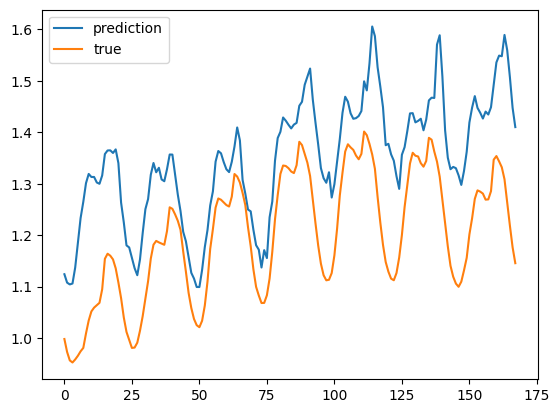

In [26]:
pred_fixed=np.array(predictions[::7]).flatten()
plt.plot(pred_fixed[:24*7])
plt.plot(val.values.flatten()[:24*7])
plt.legend(['prediction','true'])

## Ensemble SARIMA+XGBoost

In [10]:
class ManualMultiOutputXGB:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        import numpy as np
        return np.column_stack([model.predict(X) for model in self.models])

def transform_data(df):
    def add_fourier_terms(df, period, order):
        for k in range(1, order + 1):
            df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * df.index.hour / period)
            df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * df.index.hour / period)

    ml_df=df.copy()
    ml_df['day_of_week']=ml_df.index.dayofweek
    ml_df['day_of_year']=ml_df.index.dayofyear
    ml_df['month']=ml_df.index.month
    ml_df['weekend']=ml_df['day_of_week']>=5
    
    ml_df['lag_12']=ml_df['y'].shift(12)
    ml_df['lag_24']=ml_df['y'].shift(24)
    ml_df['lag_168']=ml_df['y'].shift(168)
    
    ml_df['rolling_mean_24']=ml_df['y'].shift(1).rolling(24).mean()
    ml_df['rolling_std_24']=ml_df['y'].shift(1).rolling(24).std()
    ml_df['rolling_mean_168']=ml_df['y'].shift(1).rolling(168).mean()
    
    add_fourier_terms(ml_df,24,2)
    add_fourier_terms(ml_df,168,2)
    add_fourier_terms(ml_df,24*365,2)
    
    targets = {
        f'y_{h}': ml_df['y'].shift(-h) for h in range(1, 169)
    }
    
    targets_df = pd.concat(targets.values(), axis=1)
    targets_df.columns=targets.keys()
    ml_df=pd.concat([ml_df,targets_df],axis=1)
    
    targ_col = [f'y_{h}' for h in range(1, 169)]
    
    ml_df=ml_df.dropna()
    
    ml_val=ml_df['2024-01-01 01':'2024-06-01'].iloc[:-168]
    ml_tr=ml_df[:'2024-01-01 00']
    ml_val=pd.concat([ml_val,ml_tr.iloc[[-1]]])
    ml_val=ml_val.sort_index()
    ml_tr=ml_tr.iloc[:-168]
    
    X=ml_tr.drop(targ_col,axis=1)
    y=ml_tr[targ_col]
    
    X_val=ml_val.drop(targ_col,axis=1)
    y_val=ml_val[targ_col]
    return X,y,X_val,y_val


In [11]:
X,y,X_val,y_val=transform_data(df)
models = []
for i, col in enumerate(y.columns):
    print(f"Training model for target: {col}")
    model = xgb.XGBRegressor(
        n_estimators=5000,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1,
        reg_lambda=1,
        random_state=42,
        early_stopping_rounds=50,
    )
    model.fit(
        X, y[col],
        eval_set=[(X_val, y_val[col])],
        verbose=100
    )
    models.append(model)


Training model for target: y_1
[0]	validation_0-rmse:0.19657
[100]	validation_0-rmse:0.01707
[200]	validation_0-rmse:0.01482
[300]	validation_0-rmse:0.01386
[400]	validation_0-rmse:0.01322
[500]	validation_0-rmse:0.01283
[600]	validation_0-rmse:0.01261
[700]	validation_0-rmse:0.01245
[800]	validation_0-rmse:0.01233
[900]	validation_0-rmse:0.01224
[1000]	validation_0-rmse:0.01216
[1100]	validation_0-rmse:0.01209
[1200]	validation_0-rmse:0.01205
[1300]	validation_0-rmse:0.01200
[1400]	validation_0-rmse:0.01197
[1500]	validation_0-rmse:0.01193
[1600]	validation_0-rmse:0.01191
[1700]	validation_0-rmse:0.01189
[1800]	validation_0-rmse:0.01186
[1900]	validation_0-rmse:0.01184
[2000]	validation_0-rmse:0.01183
[2100]	validation_0-rmse:0.01182
[2200]	validation_0-rmse:0.01179
[2300]	validation_0-rmse:0.01178
[2400]	validation_0-rmse:0.01177
[2500]	validation_0-rmse:0.01175
[2600]	validation_0-rmse:0.01174
[2700]	validation_0-rmse:0.01173
[2800]	validation_0-rmse:0.01173
[2900]	validation_0-rmse

In [12]:
XG_model=ManualMultiOutputXGB(models)

In [13]:
def make_ensemble_prediction(data,start,XG_model,horizon=168):
    try:
        print('hello')
        model = make_sarima(data.iloc[max(start - 4380, 0):start])
        sa_prediction = model.forecast(horizon)
        forecast_index = data.index[start:start + horizon]
        sa_prediction.index = forecast_index

        # 2. XGBoost prediction
        xg_x, _, _, _ = transform_data(data.iloc[:start])
        xg_x = xg_x.iloc[[-1]]  # keep as DataFrame with one row
        xg_prediction = XG_model.predict(xg_x).flatten()
        xg_prediction = pd.Series(xg_prediction, index=forecast_index)

        aver_pred = (sa_prediction.values + xg_prediction.values) / 2
        aver_pred = pd.Series(aver_pred, index=forecast_index)      
        
        actual_one = data.iloc[start:start + horizon]['y']
        actual_one.index = forecast_index  # just to be safe        return aver_pred,actual_one

        return aver_pred, actual_one
    except Exception as e:
        print(f"Error at start={start}: {e}")
        return None


In [16]:
data=pd.concat([tr,val])
pos=data.index.get_loc(val.index[0])
hours=range(pos,len(data)-168,24)

results=[]

In [17]:
for start in tqdm(hours):
    result = make_ensemble_prediction(data, start, XG_model, 168)
    if result:
        results.append(result)

  0%|                                                                                                                                                                                      | 0/146 [00:00<?, ?it/s]

hello


  1%|█▏                                                                                                                                                                          | 1/146 [00:29<1:10:47, 29.29s/it]

hello


  1%|██▎                                                                                                                                                                         | 2/146 [00:56<1:07:33, 28.15s/it]

hello


  2%|███▌                                                                                                                                                                        | 3/146 [01:32<1:15:34, 31.71s/it]

hello


  3%|████▋                                                                                                                                                                       | 4/146 [02:00<1:11:54, 30.38s/it]

hello


  3%|█████▉                                                                                                                                                                      | 5/146 [02:21<1:03:27, 27.00s/it]

hello


  4%|███████                                                                                                                                                                     | 6/146 [03:00<1:12:14, 30.96s/it]

hello


  5%|████████▏                                                                                                                                                                   | 7/146 [03:29<1:10:17, 30.34s/it]

hello


  5%|█████████▍                                                                                                                                                                  | 8/146 [04:06<1:14:41, 32.47s/it]

hello


  6%|██████████▌                                                                                                                                                                 | 9/146 [04:44<1:17:43, 34.04s/it]

hello


  7%|███████████▋                                                                                                                                                               | 10/146 [05:12<1:13:30, 32.43s/it]

hello


  8%|████████████▉                                                                                                                                                              | 11/146 [05:46<1:13:44, 32.77s/it]

hello


  8%|██████████████                                                                                                                                                             | 12/146 [06:13<1:09:20, 31.05s/it]

hello


  9%|███████████████▏                                                                                                                                                           | 13/146 [06:45<1:09:32, 31.37s/it]

hello


 10%|████████████████▍                                                                                                                                                          | 14/146 [07:18<1:09:56, 31.79s/it]

hello


 10%|█████████████████▌                                                                                                                                                         | 15/146 [07:46<1:06:37, 30.52s/it]

hello


 11%|██████████████████▋                                                                                                                                                        | 16/146 [08:30<1:14:55, 34.58s/it]

hello


 12%|███████████████████▉                                                                                                                                                       | 17/146 [09:05<1:14:40, 34.73s/it]

hello


 12%|█████████████████████                                                                                                                                                      | 18/146 [09:29<1:07:20, 31.56s/it]

hello


 13%|██████████████████████▎                                                                                                                                                    | 19/146 [10:17<1:17:01, 36.39s/it]

hello


 14%|███████████████████████▍                                                                                                                                                   | 20/146 [10:51<1:15:13, 35.82s/it]

hello


 14%|████████████████████████▌                                                                                                                                                  | 21/146 [11:32<1:18:08, 37.51s/it]

hello


 15%|█████████████████████████▊                                                                                                                                                 | 22/146 [12:06<1:14:46, 36.18s/it]

hello


 16%|██████████████████████████▉                                                                                                                                                | 23/146 [12:40<1:12:51, 35.54s/it]

hello


 16%|████████████████████████████                                                                                                                                               | 24/146 [13:16<1:12:37, 35.71s/it]

hello


 17%|█████████████████████████████▎                                                                                                                                             | 25/146 [13:45<1:07:53, 33.66s/it]

hello


 18%|██████████████████████████████▍                                                                                                                                            | 26/146 [14:24<1:10:59, 35.50s/it]

hello


 18%|███████████████████████████████▌                                                                                                                                           | 27/146 [14:54<1:07:11, 33.88s/it]

hello


 19%|████████████████████████████████▊                                                                                                                                          | 28/146 [15:32<1:09:00, 35.09s/it]

hello


 20%|█████████████████████████████████▉                                                                                                                                         | 29/146 [16:01<1:04:38, 33.15s/it]

hello


 21%|███████████████████████████████████▏                                                                                                                                       | 30/146 [16:36<1:04:59, 33.62s/it]

hello


 21%|████████████████████████████████████▎                                                                                                                                      | 31/146 [17:13<1:06:40, 34.78s/it]

hello


 22%|█████████████████████████████████████▍                                                                                                                                     | 32/146 [17:41<1:02:08, 32.71s/it]

hello


 23%|██████████████████████████████████████▋                                                                                                                                    | 33/146 [18:22<1:05:59, 35.04s/it]

hello


 23%|███████████████████████████████████████▊                                                                                                                                   | 34/146 [19:01<1:08:06, 36.49s/it]

hello


 24%|████████████████████████████████████████▉                                                                                                                                  | 35/146 [19:37<1:06:48, 36.11s/it]

hello


 25%|██████████████████████████████████████████▏                                                                                                                                | 36/146 [20:11<1:05:29, 35.72s/it]

hello


 25%|███████████████████████████████████████████▎                                                                                                                               | 37/146 [20:54<1:08:28, 37.69s/it]

hello


 26%|████████████████████████████████████████████▌                                                                                                                              | 38/146 [21:49<1:17:20, 42.97s/it]

hello


 27%|█████████████████████████████████████████████▋                                                                                                                             | 39/146 [22:22<1:11:29, 40.09s/it]

hello


 27%|██████████████████████████████████████████████▊                                                                                                                            | 40/146 [23:03<1:11:06, 40.25s/it]

hello


 28%|████████████████████████████████████████████████                                                                                                                           | 41/146 [23:54<1:15:48, 43.32s/it]

hello


 29%|█████████████████████████████████████████████████▏                                                                                                                         | 42/146 [24:31<1:12:05, 41.59s/it]

hello


 29%|██████████████████████████████████████████████████▎                                                                                                                        | 43/146 [25:03<1:06:11, 38.56s/it]

hello


 30%|███████████████████████████████████████████████████▌                                                                                                                       | 44/146 [25:42<1:06:03, 38.86s/it]

hello


 31%|████████████████████████████████████████████████████▋                                                                                                                      | 45/146 [26:14<1:01:55, 36.79s/it]

hello


 32%|█████████████████████████████████████████████████████▉                                                                                                                     | 46/146 [26:49<1:00:34, 36.35s/it]

hello


 32%|███████████████████████████████████████████████████████▋                                                                                                                     | 47/146 [27:20<57:00, 34.55s/it]

hello


 33%|████████████████████████████████████████████████████████▏                                                                                                                  | 48/146 [28:11<1:04:47, 39.66s/it]

hello


 34%|██████████████████████████████████████████████████████████                                                                                                                   | 49/146 [28:41<59:23, 36.73s/it]

hello


 34%|███████████████████████████████████████████████████████████▏                                                                                                                 | 50/146 [29:20<59:41, 37.31s/it]

hello


 35%|████████████████████████████████████████████████████████████▍                                                                                                                | 51/146 [29:58<59:35, 37.64s/it]

hello


 36%|█████████████████████████████████████████████████████████████▌                                                                                                               | 52/146 [30:32<57:05, 36.44s/it]

hello


 36%|██████████████████████████████████████████████████████████████▊                                                                                                              | 53/146 [31:11<57:44, 37.26s/it]

hello


 37%|███████████████████████████████████████████████████████████████▉                                                                                                             | 54/146 [31:49<57:16, 37.35s/it]

hello


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                           | 55/146 [32:21<54:10, 35.72s/it]

hello


 38%|██████████████████████████████████████████████████████████████████▎                                                                                                          | 56/146 [33:00<55:08, 36.77s/it]

hello


 39%|███████████████████████████████████████████████████████████████████▌                                                                                                         | 57/146 [33:37<54:52, 36.99s/it]

hello


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                        | 58/146 [34:12<53:24, 36.41s/it]

hello


 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                       | 59/146 [34:54<54:59, 37.93s/it]

hello


 41%|███████████████████████████████████████████████████████████████████████                                                                                                      | 60/146 [35:33<54:52, 38.29s/it]

hello


 42%|████████████████████████████████████████████████████████████████████████▎                                                                                                    | 61/146 [36:19<57:23, 40.52s/it]

hello


 42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                   | 62/146 [36:55<54:47, 39.14s/it]

hello


 43%|██████████████████████████████████████████████████████████████████████████▋                                                                                                  | 63/146 [37:27<51:12, 37.02s/it]

hello


 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                                 | 64/146 [38:00<49:11, 35.99s/it]

hello


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                                | 65/146 [38:33<47:24, 35.11s/it]

hello


 45%|█████████████████████████████████████████████████████████████████████████████▎                                                                                             | 66/146 [39:51<1:03:44, 47.81s/it]

hello


 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                             | 67/146 [40:21<56:00, 42.54s/it]

hello


 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 68/146 [40:58<53:06, 40.85s/it]

hello


 47%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 69/146 [41:49<56:13, 43.81s/it]

hello


 48%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 70/146 [42:21<51:18, 40.51s/it]

hello


 49%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 71/146 [42:55<47:50, 38.27s/it]

hello


 49%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 72/146 [43:32<46:47, 37.94s/it]

hello


 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 73/146 [44:10<46:26, 38.17s/it]

hello


 51%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 74/146 [44:50<46:08, 38.46s/it]

hello


/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 51%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 75/146 [45:31<46:26, 39.25s/it]

hello


 52%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 76/146 [46:02<43:01, 36.88s/it]

hello


 53%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 77/146 [46:47<45:04, 39.19s/it]

hello


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 78/146 [47:28<45:09, 39.84s/it]

hello


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 79/146 [48:23<49:40, 44.49s/it]

hello


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 80/146 [48:58<45:44, 41.58s/it]

hello


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 81/146 [49:32<42:35, 39.31s/it]

hello


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 82/146 [50:35<49:28, 46.39s/it]

hello


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 83/146 [51:24<49:33, 47.20s/it]

hello


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 84/146 [51:55<43:36, 42.19s/it]

hello


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 85/146 [52:55<48:25, 47.63s/it]

hello


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 86/146 [53:25<42:19, 42.32s/it]

hello


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 87/146 [53:58<38:50, 39.50s/it]

hello


/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 88/146 [54:32<36:45, 38.03s/it]

hello


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 89/146 [55:33<42:39, 44.90s/it]

hello


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 90/146 [56:14<40:49, 43.74s/it]

hello


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 91/146 [56:39<34:52, 38.05s/it]

hello


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 92/146 [57:25<36:17, 40.33s/it]

hello


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 93/146 [57:55<32:56, 37.29s/it]

hello


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 94/146 [58:57<38:43, 44.69s/it]

hello


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 95/146 [59:28<34:36, 40.72s/it]

hello


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 96/146 [1:00:22<37:17, 44.75s/it]

hello


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 97/146 [1:00:55<33:26, 40.94s/it]

hello


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 98/146 [1:01:34<32:30, 40.64s/it]

hello


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 99/146 [1:02:55<41:19, 52.75s/it]

hello


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 100/146 [1:03:27<35:36, 46.45s/it]

hello


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 101/146 [1:04:10<33:54, 45.22s/it]

hello


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 102/146 [1:04:39<29:41, 40.50s/it]

hello


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 103/146 [1:05:13<27:38, 38.58s/it]

hello


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 104/146 [1:05:52<26:59, 38.55s/it]

hello


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 105/146 [1:06:24<25:02, 36.64s/it]

hello


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 106/146 [1:07:08<25:50, 38.77s/it]

hello


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 107/146 [1:07:45<24:59, 38.45s/it]

hello


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 108/146 [1:08:41<27:39, 43.67s/it]

hello


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 109/146 [1:09:45<30:39, 49.71s/it]

hello


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 110/146 [1:10:54<33:21, 55.61s/it]

hello


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 111/146 [1:11:29<28:48, 49.38s/it]

hello


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 112/146 [1:12:14<27:11, 48.00s/it]

hello


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 113/146 [1:12:55<25:18, 46.03s/it]

hello


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 114/146 [1:13:37<23:55, 44.87s/it]

hello


/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 115/146 [1:14:21<22:58, 44.47s/it]

hello


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 116/146 [1:15:26<25:21, 50.72s/it]

hello


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 117/146 [1:16:17<24:30, 50.70s/it]

hello


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 118/146 [1:16:51<21:19, 45.69s/it]

hello


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 119/146 [1:17:21<18:29, 41.10s/it]

hello


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 120/146 [1:18:22<20:23, 47.07s/it]

hello


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 121/146 [1:19:21<21:00, 50.43s/it]

hello


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 122/146 [1:20:06<19:32, 48.87s/it]

hello


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 123/146 [1:20:55<18:45, 48.95s/it]

hello


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 124/146 [1:21:29<16:15, 44.35s/it]

hello


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 125/146 [1:22:03<14:31, 41.48s/it]

hello


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 126/146 [1:22:39<13:15, 39.79s/it]

hello


/home/tip/projects/main/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 127/146 [1:23:28<13:26, 42.46s/it]

hello


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 128/146 [1:24:28<14:18, 47.69s/it]

hello


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 129/146 [1:25:03<12:24, 43.81s/it]

hello


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 130/146 [1:25:43<11:22, 42.66s/it]

hello


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 131/146 [1:26:24<10:32, 42.20s/it]

hello


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 132/146 [1:27:06<09:53, 42.37s/it]

hello


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 133/146 [1:28:09<10:29, 48.39s/it]

hello


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 134/146 [1:34:21<29:06, 145.58s/it]

hello


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 135/146 [1:35:06<21:09, 115.40s/it]

hello


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 136/146 [1:36:12<16:45, 100.57s/it]

hello


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 137/146 [1:37:24<13:46, 91.85s/it]

hello


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 138/146 [1:38:15<10:37, 79.64s/it]

hello


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 139/146 [1:38:50<07:43, 66.18s/it]

hello


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 140/146 [1:39:39<06:07, 61.27s/it]

hello


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 141/146 [1:40:39<05:03, 60.66s/it]

hello


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 142/146 [1:41:14<03:32, 53.03s/it]

hello


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 143/146 [1:41:48<02:22, 47.33s/it]

hello


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 144/146 [1:42:29<01:30, 45.47s/it]

hello


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 145/146 [1:43:11<00:44, 44.47s/it]

hello


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [1:44:04<00:00, 42.77s/it]


<Axes: >

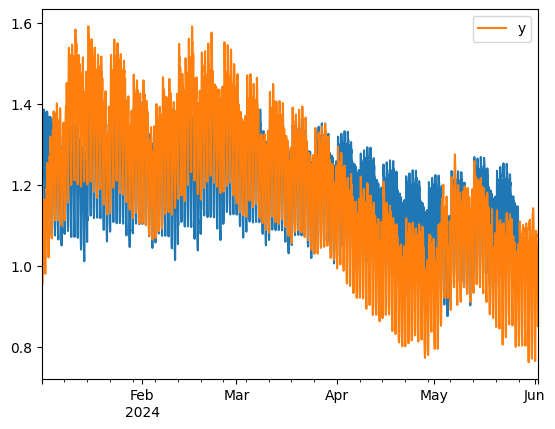

In [26]:
predictions,actuals=zip(*results)
pred_fixed=pd.concat(predictions[::7])
ax=pred_fixed.plot()
val.plot(ax=ax)

In [28]:
residuals=[actuals[x]-predictions[x] for x in range(len(actuals))]
np.mean(np.abs(residuals))

0.08120360139472271

In [15]:
with keep.running():
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(make_ensemble_prediction, data, start,XG_model,168) for start in hours]
        with tqdm(total=len(futures)) as pbar:
            for f in as_completed(futures):
                try:
                    res = f.result()
                    if res:
                        results.append(res)
                except Exception as e:
                    print("Error in forecast step:", e)
                pbar.update(1)
notify('finished')

Process ForkProcess-9:                                                                                                                                                                     | 0/146 [00:09<?, ?it/s]
Process ForkProcess-12:
Process ForkProcess-11:
Process ForkProcess-8:
Process ForkProcess-10:
Process ForkProcess-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _boots

KeyboardInterrupt: 

## RNN (for learning, not optimized)

In [ ]:
trd=tf.data.Dataset.from_tensor_slices(tr)
def to_windows(ds,lenght):
    windows=ds.window(lenght,shift=1,drop_remainder=True)
    windows=windows.flat_map(lambda x: x.batch(lenght))
    return windows
def seq2seq(ds,ahead,time_steps=12,batches=32):
    ods=to_windows(to_windows(ds,ahead+1),time_steps)
    ods=ods.map(lambda x: (x[:,0],x[:,1:]))
    return ods
# def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
#                        batch_size=32, shuffle=False, seed=None):
#     ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
#     ds = to_windows(ds, seq_length).map(
#         lambda S: (S[:, 0], S[:, 1:]))
#     return ds.batch(batch_size)

seq2seq(r,3)


In [54]:
trd=seq2seq(tf.data.Dataset.from_tensor_slices(tr),24)
vald=seq2seq(tf.data.Dataset.from_tensor_slices(val),24)
for x in trd.take(1):
    print(x)

(<tf.Tensor: shape=(12, 1), dtype=float64, numpy=
array([[1.091008],
       [1.071098],
       [1.047833],
       [1.029009],
       [1.022884],
       [1.030677],
       [1.036747],
       [1.041087],
       [1.044772],
       [1.073688],
       [1.096748],
       [1.104408]])>, <tf.Tensor: shape=(12, 24, 1), dtype=float64, numpy=
array([[[1.071098],
        [1.047833],
        [1.029009],
        [1.022884],
        [1.030677],
        [1.036747],
        [1.041087],
        [1.044772],
        [1.073688],
        [1.096748],
        [1.104408],
        [1.105616],
        [1.104006],
        [1.107988],
        [1.138289],
        [1.188511],
        [1.192291],
        [1.183701],
        [1.177053],
        [1.159081],
        [1.121545],
        [1.085954],
        [1.043958],
        [1.014709]],

       [[1.047833],
        [1.029009],
        [1.022884],
        [1.030677],
        [1.036747],
        [1.041087],
        [1.044772],
        [1.073688],
        [1.096748],
    

In [72]:
rnn=tf.keras.models.Sequential([
    tf.keras.layers.Input([None,1]),
    tf.keras.layers.LSTM(50,return_sequences=True),
    tf.keras.layers.Dense(24)
])
early_stop=tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
rnn.compile(loss='mean_absolute_error',optimizer='nadam')
rnn.fit(trd,validation_data=vald,epochs=500,callbacks=[early_stop],steps_per_epoch=18949)

Epoch 1/500
18949/18949 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.1224 - val_loss: 0.2657
Epoch 2/500
18949/18949 ━━━━━━━━━━━━━━━━━━━━ 2s 117us/step - loss: 0.0000e+00 - val_loss: 0.2657
Epoch 3/500
18949/18949 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - loss: 0.0892 - val_loss: 0.2657
Epoch 4/500


2025-05-13 19:26:35.792843: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


18949/18949 ━━━━━━━━━━━━━━━━━━━━ 2s 118us/step - loss: 0.0000e+00 - val_loss: 0.2657
Epoch 5/500
18949/18949 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.0893 - val_loss: 0.2648
Epoch 6/500
18949/18949 ━━━━━━━━━━━━━━━━━━━━ 2s 123us/step - loss: 0.0000e+00 - val_loss: 0.2648
Epoch 7/500
18949/18949 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 0.0894 - val_loss: 0.2651
Epoch 8/500
18949/18949 ━━━━━━━━━━━━━━━━━━━━ 2s 127us/step - loss: 0.0000e+00 - val_loss: 0.2651


In [73]:
rnn.evaluate(vald)

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1816


0.26479196548461914

# Old code

In [1]:
import dill
dill.load_session('notebook.db')
# dill.dump_session('notebook.db')

2025-06-03 14:09:53.810325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748956193.911525    7357 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748956193.933548    7357 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-03 14:09:54.194452: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


EOFError: Ran out of input

In [ ]:
# import logging

# # Suppress cmdstanpy INFO logs

# trc=tr.copy()
# valc=val.iloc[:-168].copy()
# pro_pred=np.array([])

# logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
# logging.getLogger("prophet").setLevel(logging.WARNING)

# with keep.running():
#     with tqdm(total=len(val)//24-168+1) as pbar:
#         for _ in range(0,len(val)-168+1,24):
#             pbar.set_postfix(leng=len(pro_pred))
#             _,pred=make_prophe(trc)
#             pro_pred=np.append(pro_pred,pred)
#             trc=pd.concat([trc,valc.iloc[:24]])
#             valc=valc.drop(valc.iloc[:24].index)
#             pbar.update(1)